# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\hp\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


#  [2] Exploratory Data Analysis

We already done EDA and prepossing of data and stored it in final.sqlite. This we will use it directly so now we don't need to do EDA and preprocessing. In Preprocessing section, we are going to use our saved final.sqlite directly.

#  [3] Preprocessing

In [2]:
#loading preprocessed data which was stored in final dataset
con = sqlite3.connect('final.sqlite') 

In [3]:
cleaned_data = pd.read_sql_query("select * from Reviews", con)
cleaned_data.shape

(364171, 12)

In [4]:
cleaned_data.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...


In [5]:
cleaned_data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [6]:
# To randomly sample 100k points from both class
random_sample_data = cleaned_data.sample(n=100000) 
random_sample_data.shape

(100000, 12)

In [7]:
# Sort data based on time
final_sorted_time=random_sample_data.sort_values('Time',ascending=True,axis=0)
final_sorted_time.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...
241,1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,b'realli good idea final product outstand use ...


In [8]:
#data splitting
y_train=final_sorted_time['Score'][0:49000]
y_cv=final_sorted_time['Score'][49000:70000]
y_test=final_sorted_time['Score'][70000:100000]
print(y_train.shape)
print(y_cv.shape)
print(y_test.shape)

(49000,)
(21000,)
(30000,)


In [9]:
train_data=final_sorted_time['CleanedText'][0:49000]
cv_data=final_sorted_time['CleanedText'][49000:70000]
test_data=final_sorted_time['CleanedText'][70000:100000]
print(train_data.shape)
print(cv_data.shape)
print(y_test.shape)

(49000,)
(21000,)
(30000,)


# [4] Featurization

## [4.1] BAG OF WORDS

In [12]:
count_vector = CountVectorizer()
bow_train = count_vector.fit_transform(train_data)
bow_cv  = count_vector.transform(cv_data)
bow_test= count_vector.transform(test_data)

In [13]:
print(bow_train.shape)
print(bow_cv.shape)
print(bow_test.shape)

(49000, 26933)
(21000, 26933)
(30000, 26933)


## [4.2] TF-IDF

In [14]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_train = tfidf_vec.fit_transform(train_data)
tf_cv  = tfidf_vec.transform(cv_data)
tf_test = tfidf_vec.transform(test_data)

## [4.3] Word2Vec

In [15]:
# Train your own Word2Vec model using your own text corpus
list_of_sent_train = []
for i in train_data:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_train.append(sent)

In [16]:
list_of_sent_cv = []
for i in cv_data:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_cv.append(sent)

In [17]:
list_of_sent_test = []
for i in test_data:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_test.append(sent)

In [18]:
print(len(list_of_sent_train))
print(len(list_of_sent_cv))
len(list_of_sent_test)

49000
21000


30000

In [19]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(list_of_sent_train,min_count = 5,size = 50,workers = 4)

In [20]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9335
sample words  ['littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'india', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'beetlejuic', 'excel', 'funni', 'movi', 'keaton', 'hilari', 'wacki', 'great', 'special', 'effect', 'help', 'film', 'think', 'one', 'best', 'ever', 'made', 'sure', 'youll', 'agre', 'good', 'time', 'watch']


## [4.3.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.3.1.1] Avg W2v

In [21]:
sent_vectors_train = []
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    if cnt_word!=0:
        sent_vec /= cnt_word
    
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))

49000


In [22]:
sent_vectors_cv = []
for sent in list_of_sent_cv:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    if cnt_word!=0:
        sent_vec /= cnt_word
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))

21000


In [23]:
sent_vectors_test = []
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    if cnt_word!=0:
        sent_vec /= cnt_word
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))

30000


#### [4.3.1.2] TFIDF weighted W2v

In [24]:
tfidf_vector = TfidfVectorizer()
tfidf_train = tfidf_vector.fit_transform(train_data)
tf_idf_feat = tfidf_vector.get_feature_names()
tfidf_sent_vec_train = []
row = 0
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tf_train[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    if weight_sum !=0:
        sent_vec/= weight_sum
    
    tfidf_sent_vec_train.append(sent_vec)
    row += 1

In [25]:
tfidf_sent_vec_cv = []
row = 0
for sent in list_of_sent_cv:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tf_cv[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    if weight_sum !=0:
        sent_vec/= weight_sum
    tfidf_sent_vec_cv.append(sent_vec)
    row += 1

In [26]:
tf_idf_feat = tfidf_vec.get_feature_names()
tfidf_sent_vec_test = []
row = 0
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tf_test[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    if weight_sum !=0:
        sent_vec/= weight_sum
    tfidf_sent_vec_test.append(sent_vec)
    row += 1

# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve

train_auc = []
cv_auc = []
train_auc_std = []
cv_auc_std = []

estimators = [50,100,200,300,400,500]
Depths = [10,20,30,40,50,60]

param_grid = {'n_estimators': estimators, 'max_depth':Depths }
RFC = RandomForestClassifier()
model = GridSearchCV(RFC, param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(bow_train, y_train)

train_auc = model.cv_results_['mean_train_score']
train_auc_std = model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

print("Model with best parameters :\n",model.best_estimator_)

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=60, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
The optimal value of depth is :  60
The optimal value of min split is :  500


In [28]:
optimal_depth = model.best_estimator_.max_depth
print("The optimal value of max depth of base model is : ",optimal_depth)

#Optimal value of n_estimators
optimal_estimator = model.best_estimator_.n_estimators
print("The optimal value of no. of base model  is : ",optimal_estimator)

The optimal value of max depth of base model is :  60
The optimal value of no. of base model  is :  500


In [29]:
# Cross-Validation errors
cv_errors = [1-i for i in model.cv_results_['mean_test_score']]

In [30]:
arr_depth=model.cv_results_['param_max_depth'] 
arr_estimator=model.cv_results_['param_n_estimators']  
#arr_rate=model.cv_results_['param_learning_rate'] 
data = [] #  List of tuples(depth,estimators)
for i in range(arr_depth.shape[0]):
    data.append(str((arr_depth[i],arr_estimator[i])))

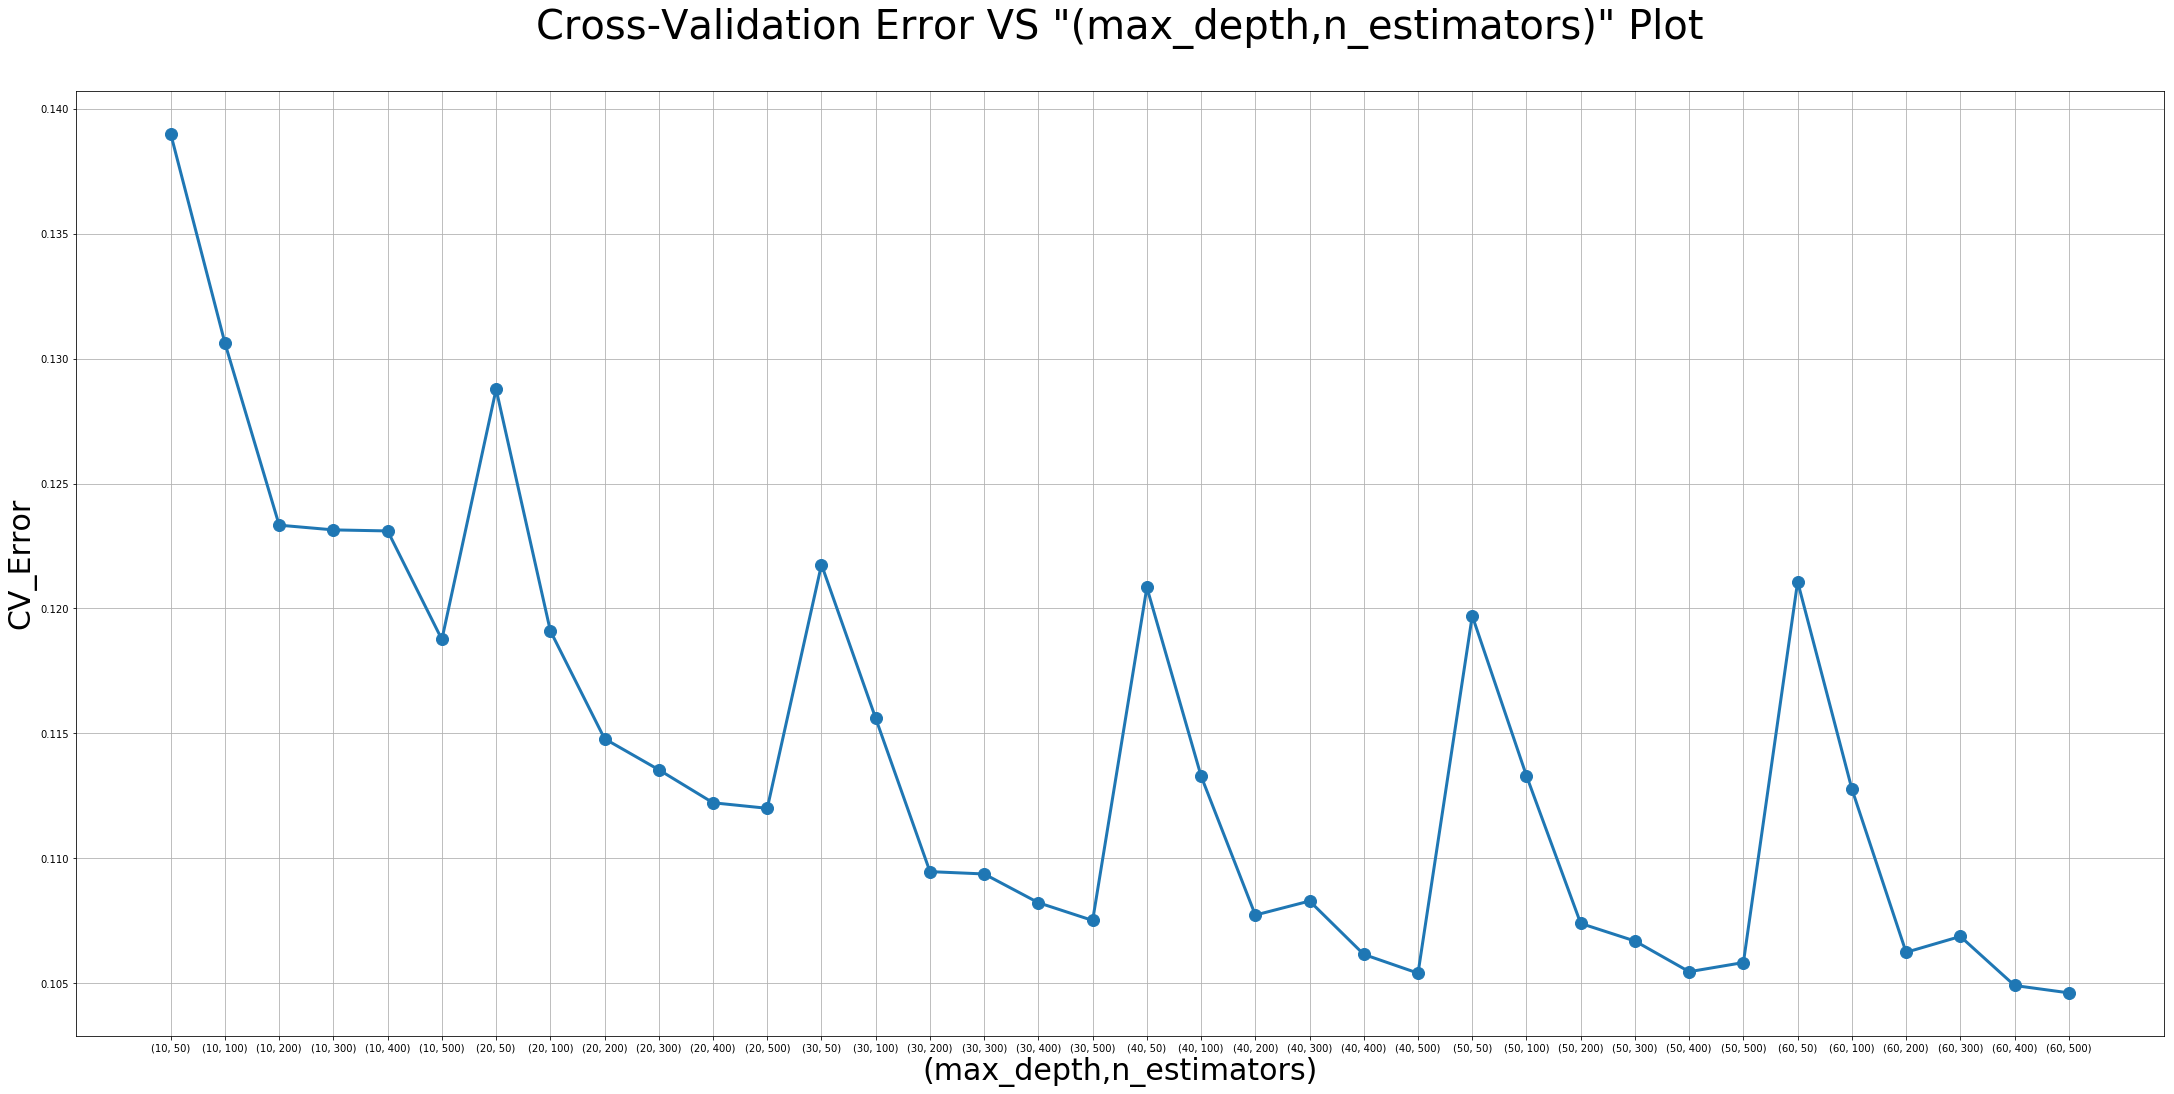

In [31]:
# plotting Cross-Validation Error vs tuples of (max_depth,n_estimators) graph  
plt.figure(figsize=(30,15))
plt.plot(data, cv_errors,linewidth=3, marker='o',markersize=12)
plt.xlabel('(max_depth,n_estimators)',size=30)
plt.ylabel('CV_Error',size=30)
plt.title('Cross-Validation Error VS "(max_depth,n_estimators)" Plot\n',size=40)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

Heatmap is also one of the reprsentation.

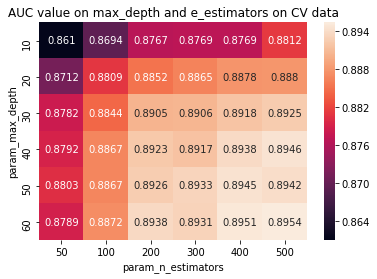

In [41]:
df_gridsearch = pd.DataFrame(model.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on CV data')
plt.show()

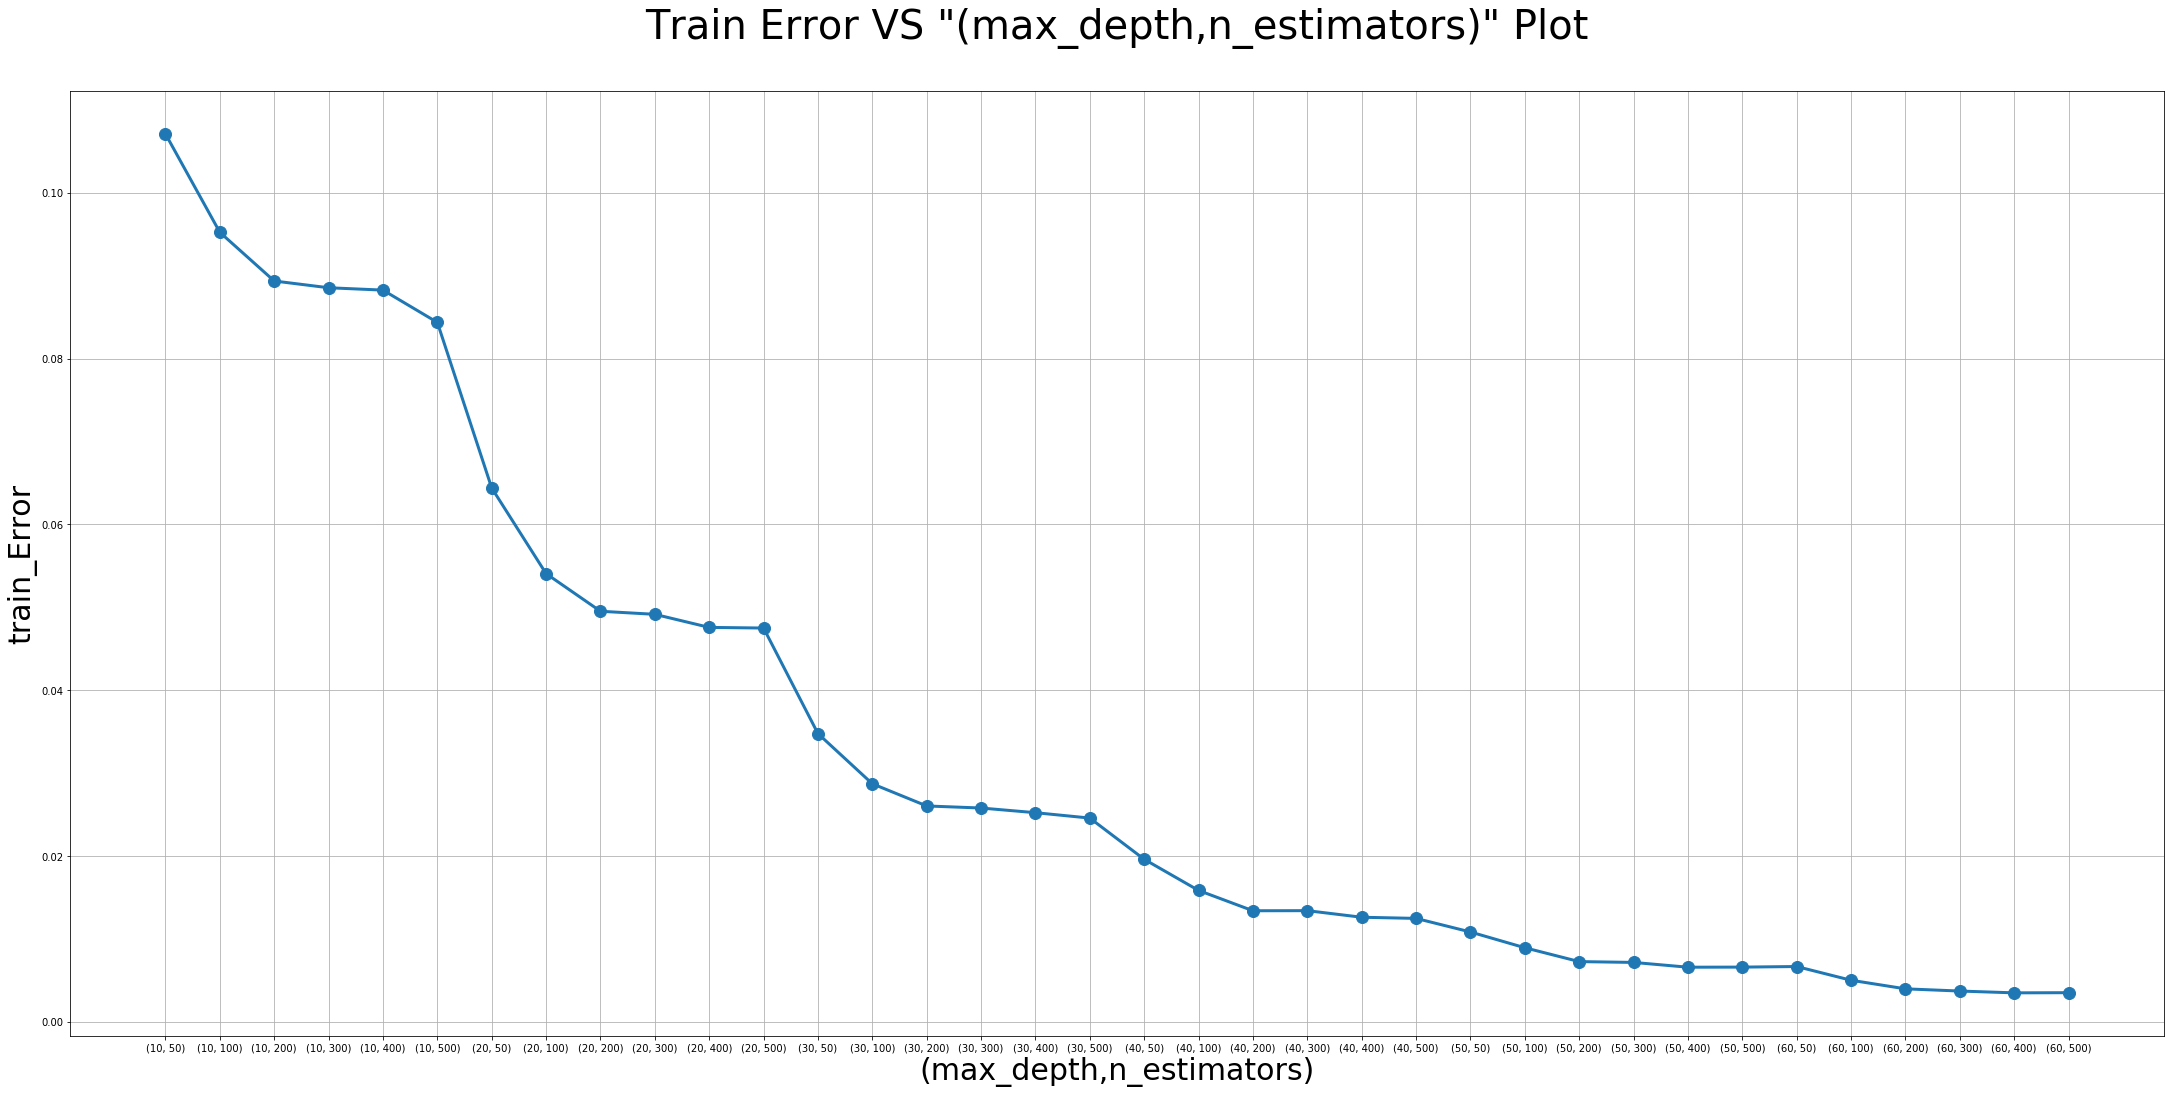

In [36]:
# Cross-Validation errors
cv_errors1 = [1-i for i in model.cv_results_['mean_train_score']]
# plotting Cross-Validation Error vs tuples of (max_depth,n_estimators) graph  
plt.figure(figsize=(30,15))
plt.plot(data, cv_errors1,linewidth=3, marker='o',markersize=12)
plt.xlabel('(max_depth,n_estimators)',size=30)
plt.ylabel('train_Error',size=30)
plt.title('Train Error VS "(max_depth,n_estimators)" Plot\n',size=40)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

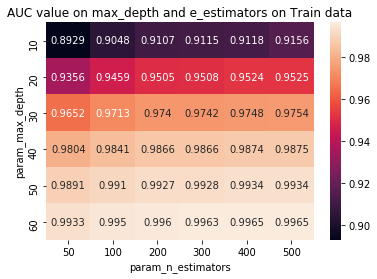

In [40]:
df_gridsearch1 = pd.DataFrame(model.cv_results_)
max_scores1 = df_gridsearch1.groupby(['param_max_depth','param_n_estimators']).max()
max_scores1 = max_scores1.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores1.mean_train_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on Train data')
plt.show()

Confusion Matrix on Train data

In [42]:
pred_train= model.predict(bow_train)
cm = confusion_matrix(y_train, pred_train)
cm

array([[ 2683,  4105],
       [    0, 42212]], dtype=int64)

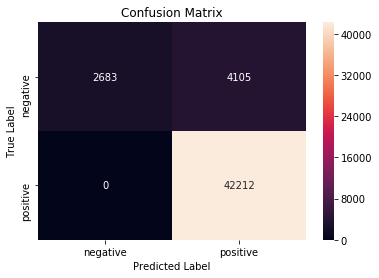

In [43]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Result on test data of BOW

In [44]:
clf = RandomForestClassifier(n_estimators=500, max_depth=60, n_jobs=-1)
clf.fit(bow_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=60, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

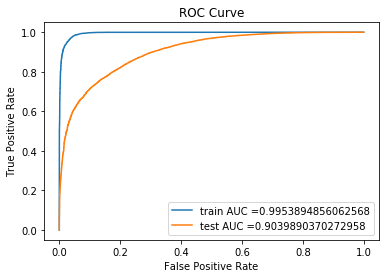

In [130]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(bow_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(bow_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

In [49]:
pred = clf.predict(bow_test)
pred_prob = clf.predict_proba(bow_test)[:,1]

In [50]:
print("AUC value on test data:",roc_auc_score(y_test, pred_prob))

AUC value on test data: 0.9039890370272958


In [51]:
cm = confusion_matrix(y_test, pred)
cm

array([[  215,  5068],
       [    4, 24713]], dtype=int64)

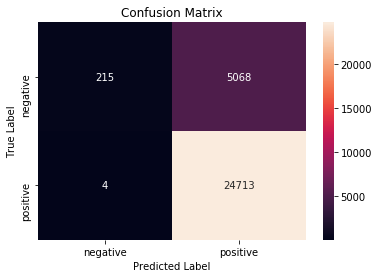

In [52]:
# plot confusion matrix to describe the performance of classifier.
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [53]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.98      0.04      0.08      5283
          1       0.83      1.00      0.91     24717

avg / total       0.86      0.83      0.76     30000



### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

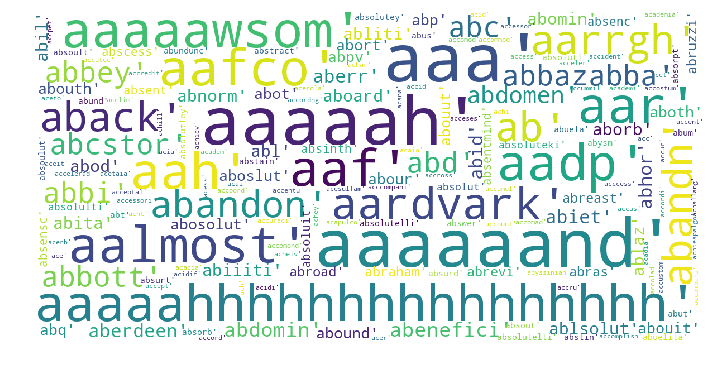

In [62]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    
    
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

names = count_vector.get_feature_names() 
show_wordcloud(names)

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [66]:
estimators = [50,100,200,300,400,500]
Depths = [10,20,30,40,50,60]

param_grid = {'n_estimators': estimators, 'max_depth':Depths }
RFC_tfidf = RandomForestClassifier()
model = GridSearchCV(RFC, param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(tf_train, y_train)

print("Model with best parameters :\n",model.best_estimator_)
##Optimal value of max_depth
optimal_depth = model.best_estimator_.max_depth
print("The optimal value of max depth of base model is : ",optimal_depth)

#Optimal value of n_estimators
optimal_estimator = model.best_estimator_.n_estimators
print("The optimal value of n_estimator is : ",optimal_estimator)

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=60, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
The optimal value of max depth of base model is :  60
The optimal value of n_estimator is :  500


Graph representation of CV error v/s Max_depth& n_estimator on cv data as follows:

In [67]:
# Cross-Validation errors
cv_errors = [1-i for i in model.cv_results_['mean_test_score']]

arr_depth=model.cv_results_['param_max_depth'] 
arr_estimator=model.cv_results_['param_n_estimators']  
#arr_rate=model.cv_results_['param_learning_rate'] 
data = [] #  List of tuples(depth,estimators)
for i in range(arr_depth.shape[0]):
    data.append(str((arr_depth[i],arr_estimator[i])))

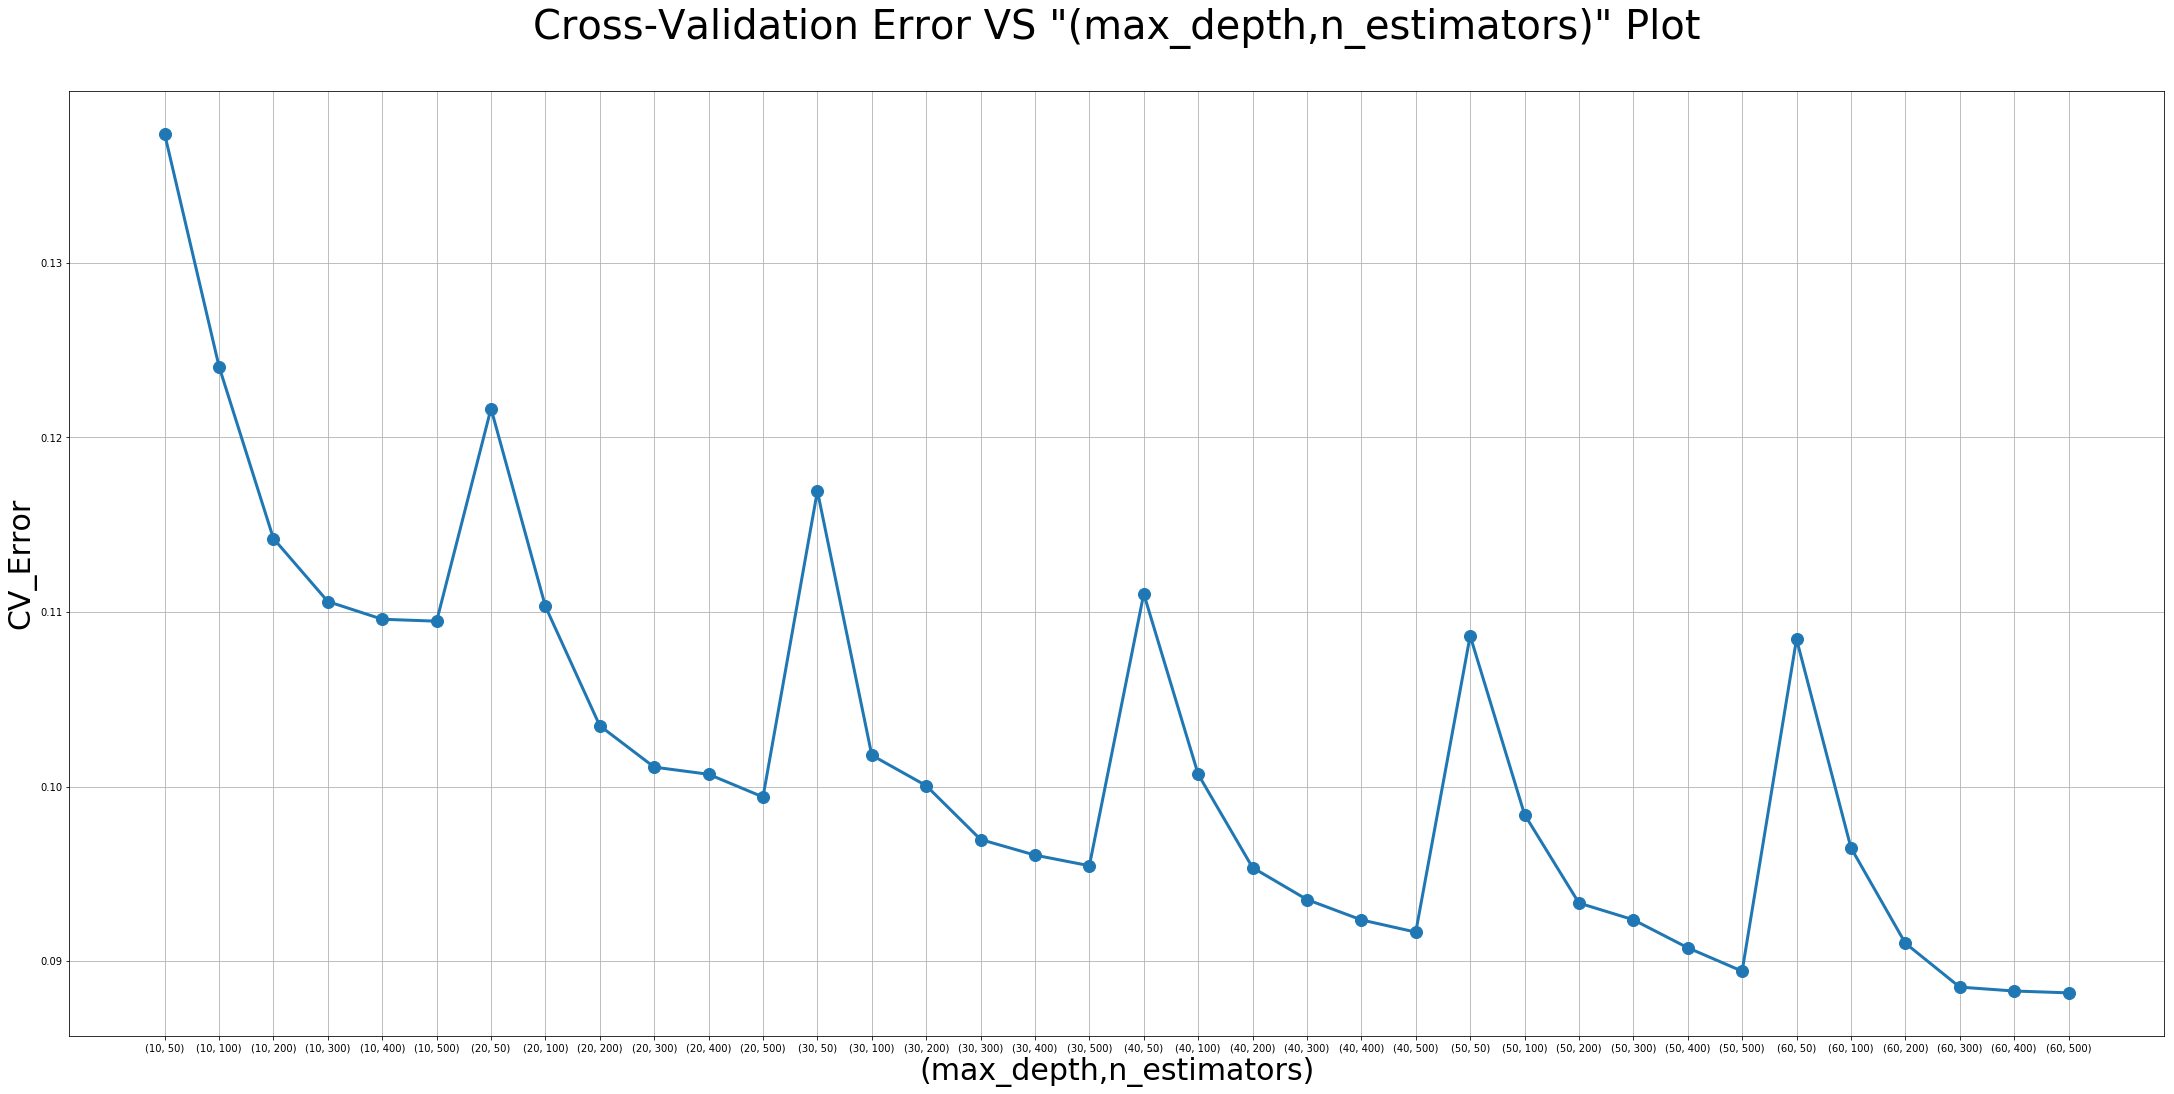

In [68]:
# plotting Cross-Validation Error vs tuples of (max_depth,n_estimators) graph  
plt.figure(figsize=(30,15))
plt.plot(data, cv_errors,linewidth=3, marker='o',markersize=12)
plt.xlabel('(max_depth,n_estimators)',size=30)
plt.ylabel('CV_Error',size=30)
plt.title('Cross-Validation Error VS "(max_depth,n_estimators)" Plot\n',size=40)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

Heatmap representation of AUC value of Max_depth & n_estimator on cv data as follows:

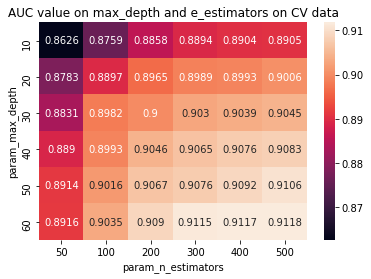

In [70]:
df_gridsearch = pd.DataFrame(model.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on CV data')
plt.show()

Graph representation of CV error v/s Max_depth & n_estimator on train data as follows:

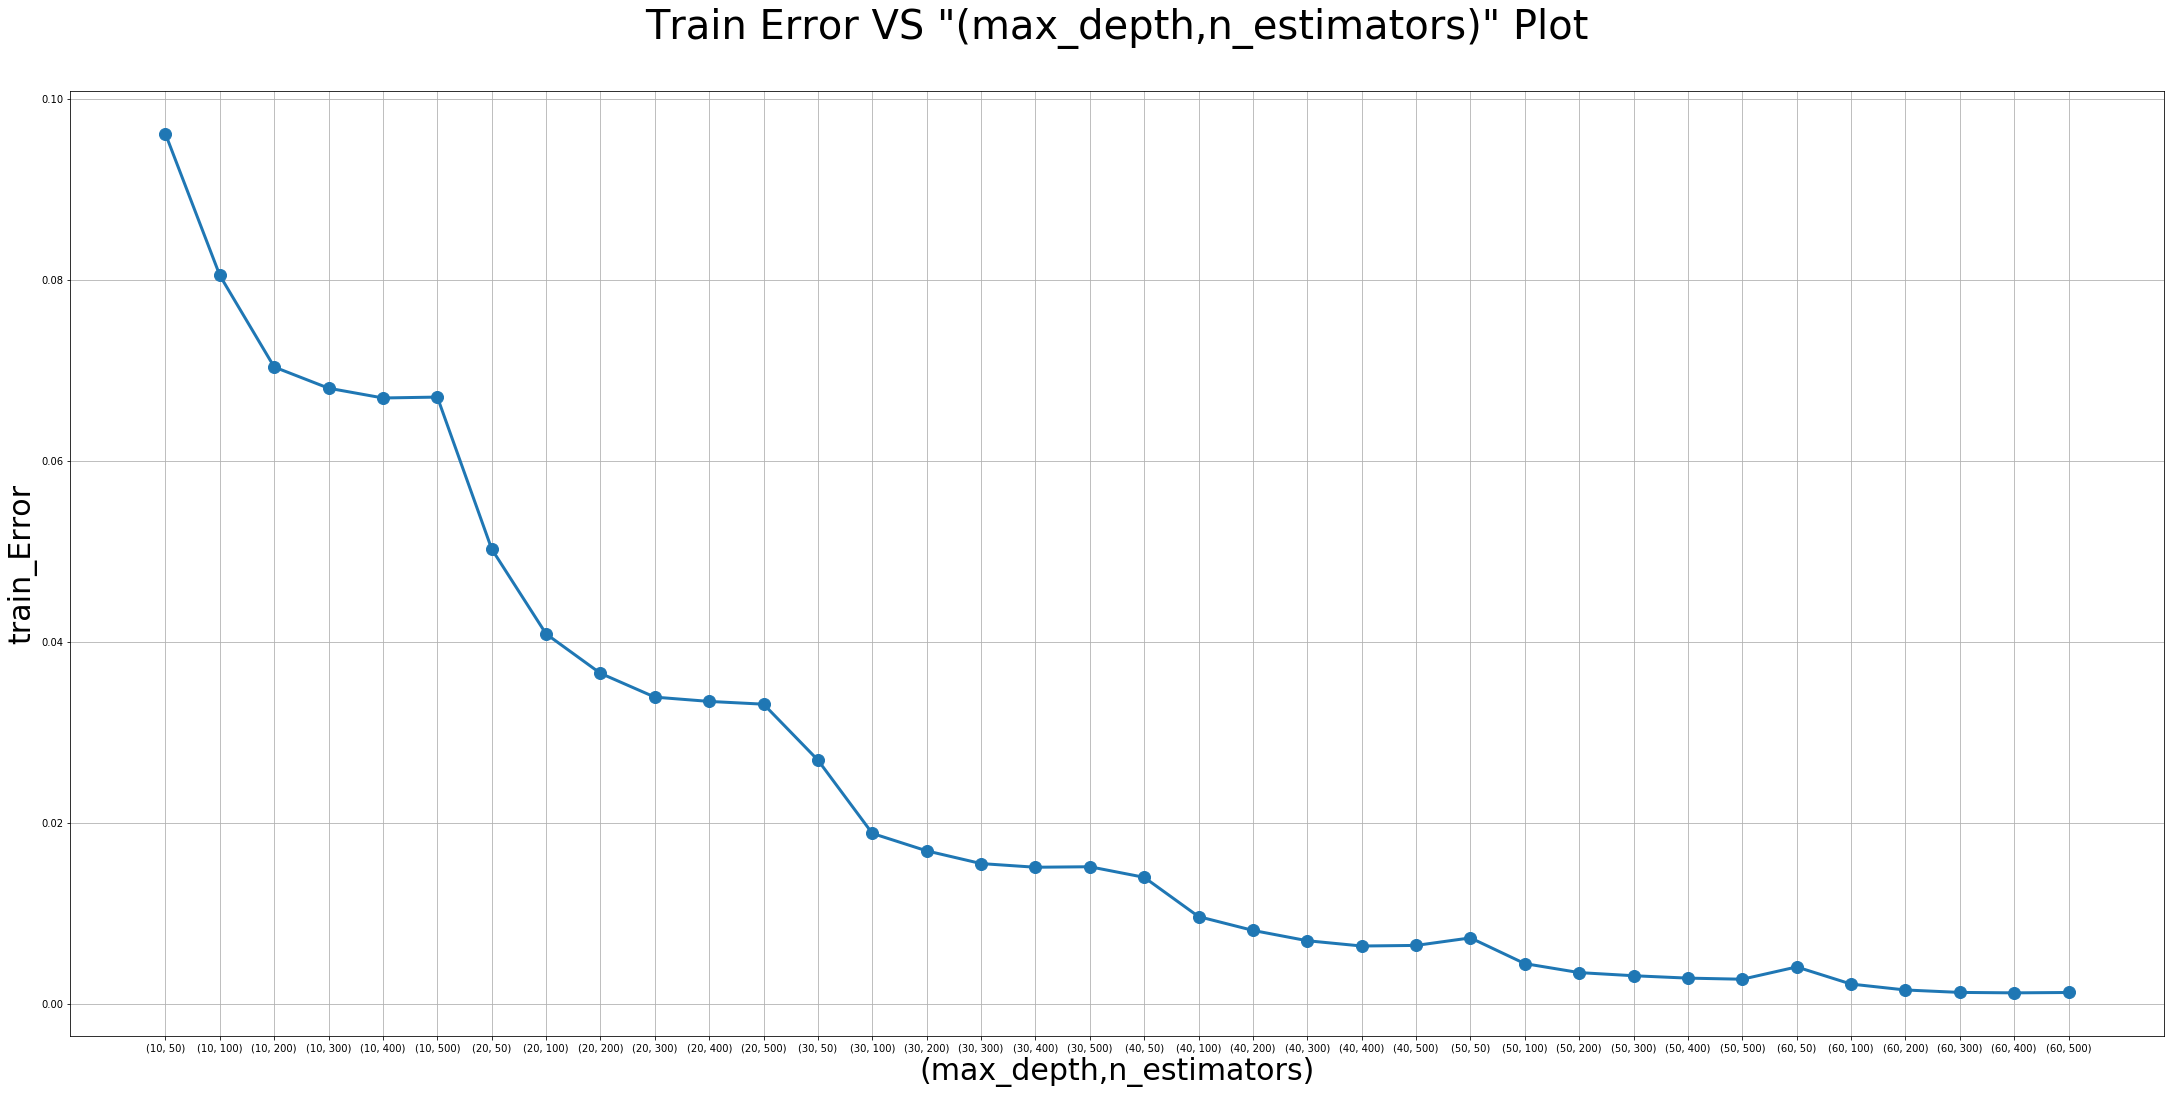

In [71]:
# Cross-Validation errors
cv_errors1 = [1-i for i in model.cv_results_['mean_train_score']]
# plotting Cross-Validation Error vs tuples of (max_depth,n_estimators) graph  
plt.figure(figsize=(30,15))
plt.plot(data, cv_errors1,linewidth=3, marker='o',markersize=12)
plt.xlabel('(max_depth,n_estimators)',size=30)
plt.ylabel('train_Error',size=30)
plt.title('Train Error VS "(max_depth,n_estimators)" Plot\n',size=40)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

Heatmap representation of AUC value of Max_depth & n_estimator on train data as follows:

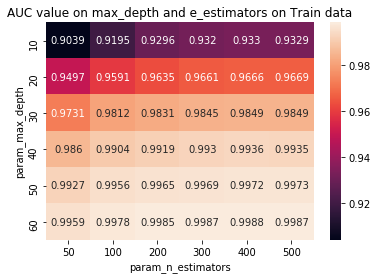

In [72]:
df_gridsearch1 = pd.DataFrame(model.cv_results_)
max_scores1 = df_gridsearch1.groupby(['param_max_depth','param_n_estimators']).max()
max_scores1 = max_scores1.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores1.mean_train_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on Train data')
plt.show()

Confusion Matrix of train data as follows:

In [73]:
pred_train= model.predict(tf_train)
cm = confusion_matrix(y_train, pred_train)
cm

array([[ 2299,  4489],
       [    0, 42212]], dtype=int64)

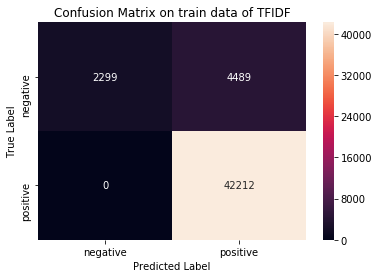

In [75]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix on train data of TFIDF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Result on test data

In [76]:
clf_tf = RandomForestClassifier(n_estimators=500, max_depth=60, n_jobs=-1)
clf_tf.fit(tf_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=60, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

ROC Curve of train data and test data as follows:

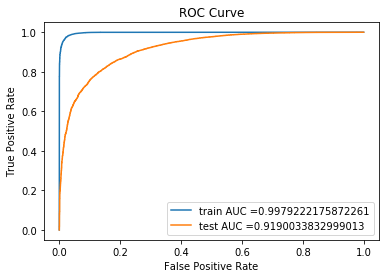

In [129]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_tf.predict_proba(tf_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_tf.predict_proba(tf_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

In [80]:
pred = clf_tf.predict(tf_test)
pred_prob = clf_tf.predict_proba(tf_test)[:,1]

print("AUC value on test data:",roc_auc_score(y_test, pred_prob))

AUC value on test data: 0.9190033832999013


Confusion Matrix on test data as follows:

In [81]:
cm = confusion_matrix(y_test, pred)
cm

array([[  423,  4860],
       [    6, 24711]], dtype=int64)

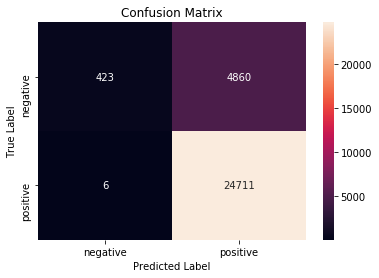

In [82]:
# plot confusion matrix to describe the performance of classifier.
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [83]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.99      0.08      0.15      5283
          1       0.84      1.00      0.91     24717

avg / total       0.86      0.84      0.78     30000



### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

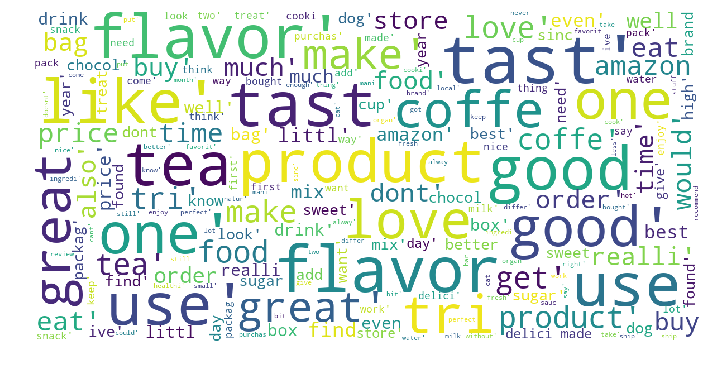

In [84]:
names_tf = tfidf_vec.get_feature_names() 
show_wordcloud(names_tf)

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [86]:
estimators = [50,100,200,300,400,500]
Depths = [10,20,30,40,50,60]

param_grid = {'n_estimators': estimators, 'max_depth':Depths }
RFC = RandomForestClassifier()
model_w2v = GridSearchCV(RFC, param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1,pre_dispatch=2)
model_w2v.fit(sent_vectors_train, y_train)


print("Model with best parameters :\n",model_w2v.best_estimator_)
##Optimal value of max_depth
optimal_depth = model.best_estimator_.max_depth
print("The optimal value of max depth of base model is : ",optimal_depth)

#Optimal value of n_estimators
optimal_estimator = model_w2v.best_estimator_.n_estimators
print("The optimal value of n_estimator is : ",optimal_estimator)

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
The optimal value of max depth of base model is :  60
The optimal value of n_estimator is :  500


Graph representation of CV error v/s Max_depth & n_estimator on cv data of AVG W2V as follows:

In [87]:
# Cross-Validation errors
cv_errors = [1-i for i in model_w2v.cv_results_['mean_test_score']]

arr_depth=model_w2v.cv_results_['param_max_depth'] 
arr_estimator=model_w2v.cv_results_['param_n_estimators']  
data = [] #  List of tuples(depth,estimators)
for i in range(arr_depth.shape[0]):
    data.append(str((arr_depth[i],arr_estimator[i])))

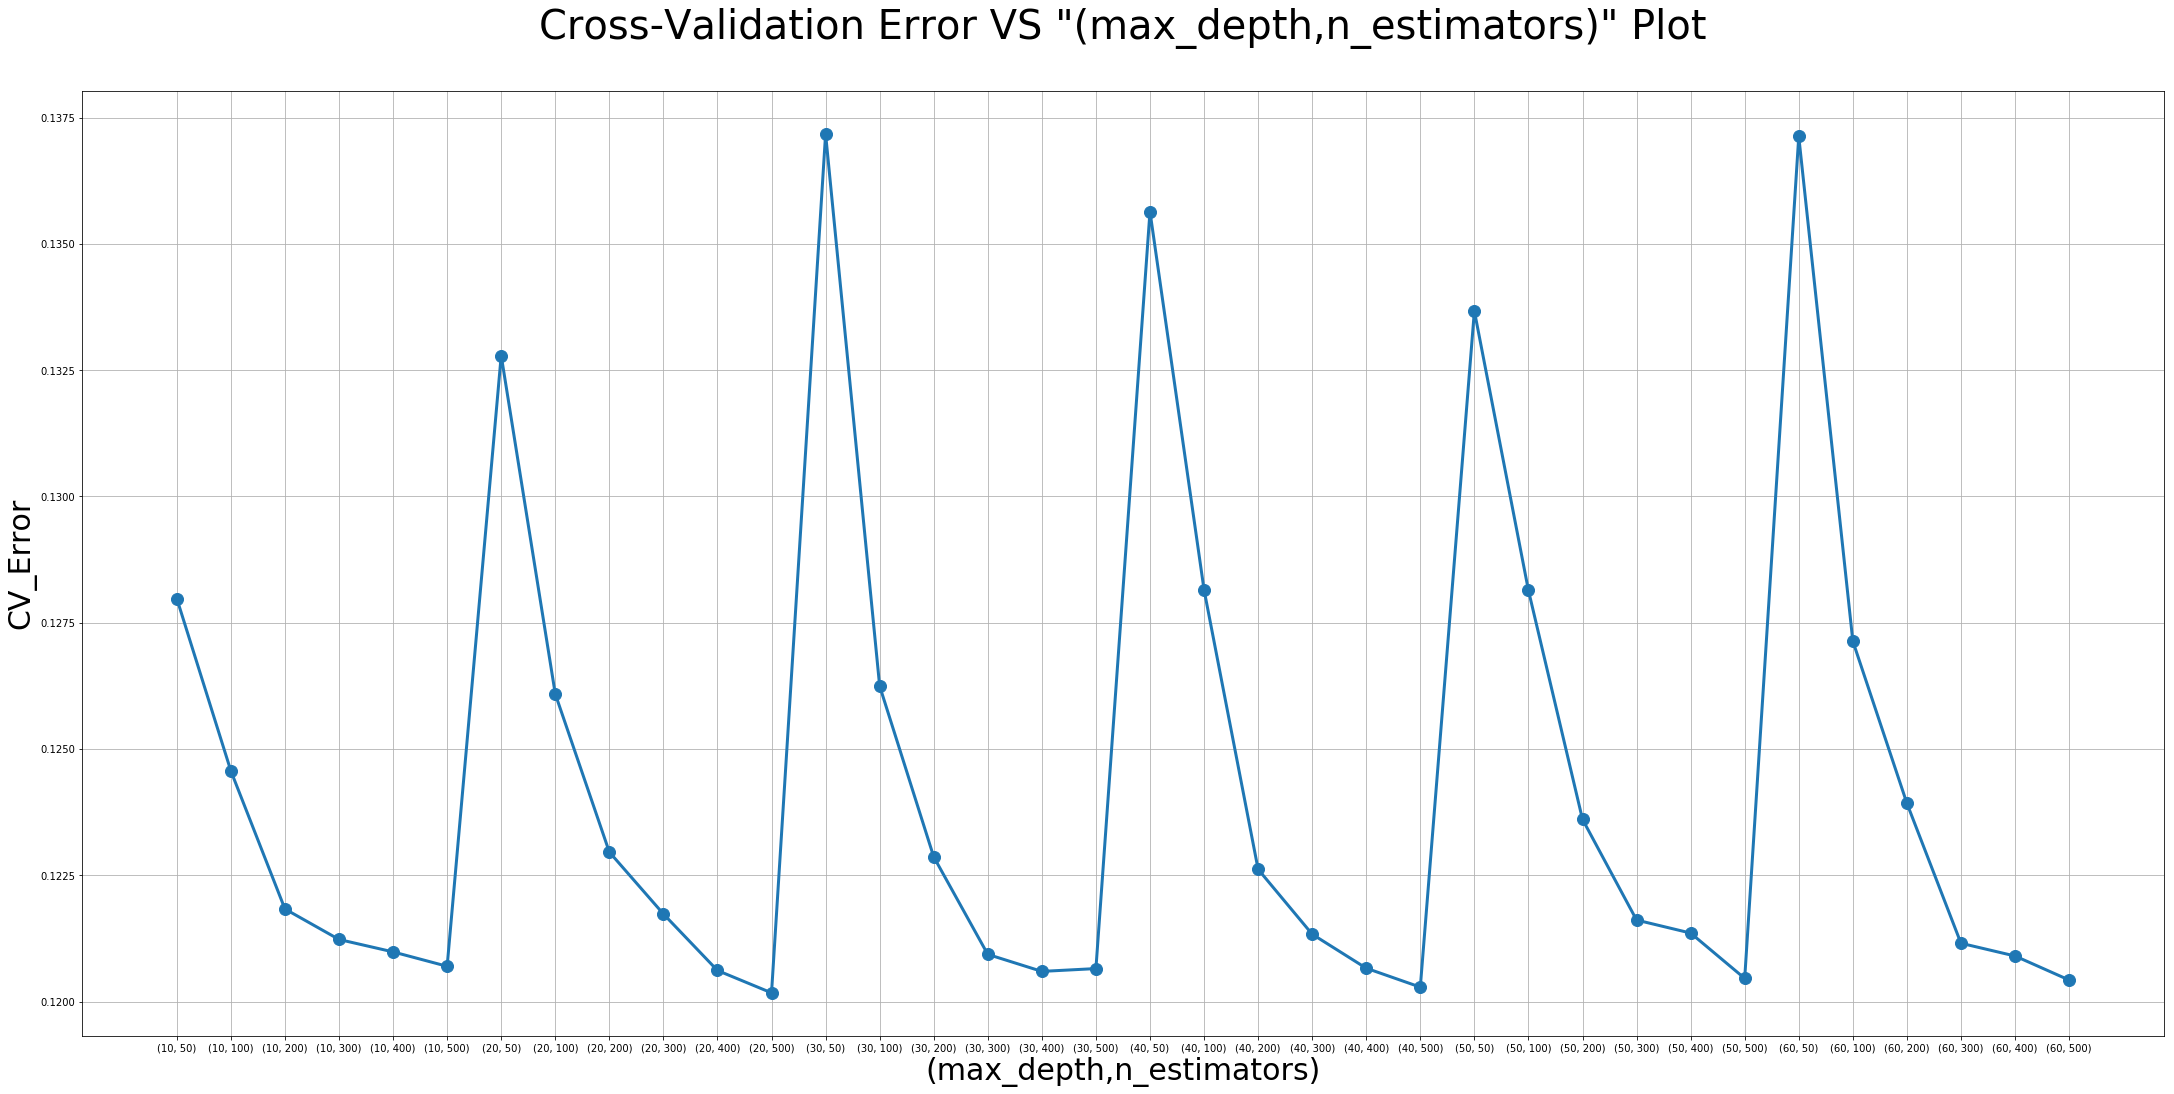

In [88]:
# plotting Cross-Validation Error vs tuples of (max_depth,n_estimators) graph  
plt.figure(figsize=(30,15))
plt.plot(data, cv_errors,linewidth=3, marker='o',markersize=12)
plt.xlabel('(max_depth,n_estimators)',size=30)
plt.ylabel('CV_Error',size=30)
plt.title('Cross-Validation Error VS "(max_depth,n_estimators)" Plot\n',size=40)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

Heatmap representation of AUC value of Max_depth & n_estimator on cv data as follows:

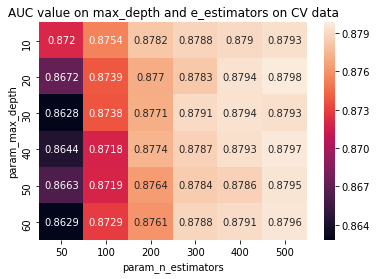

In [89]:
df_gridsearch = pd.DataFrame(model_w2v.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on CV data')
plt.show()

From above observation, max_depth=20 and n_estimator=500 gives AUC=0.8798 which is large among all columns so we will chose mentioned values. 

Graph representation of CV error v/s Max_depth & n_estimator on train data as follows:

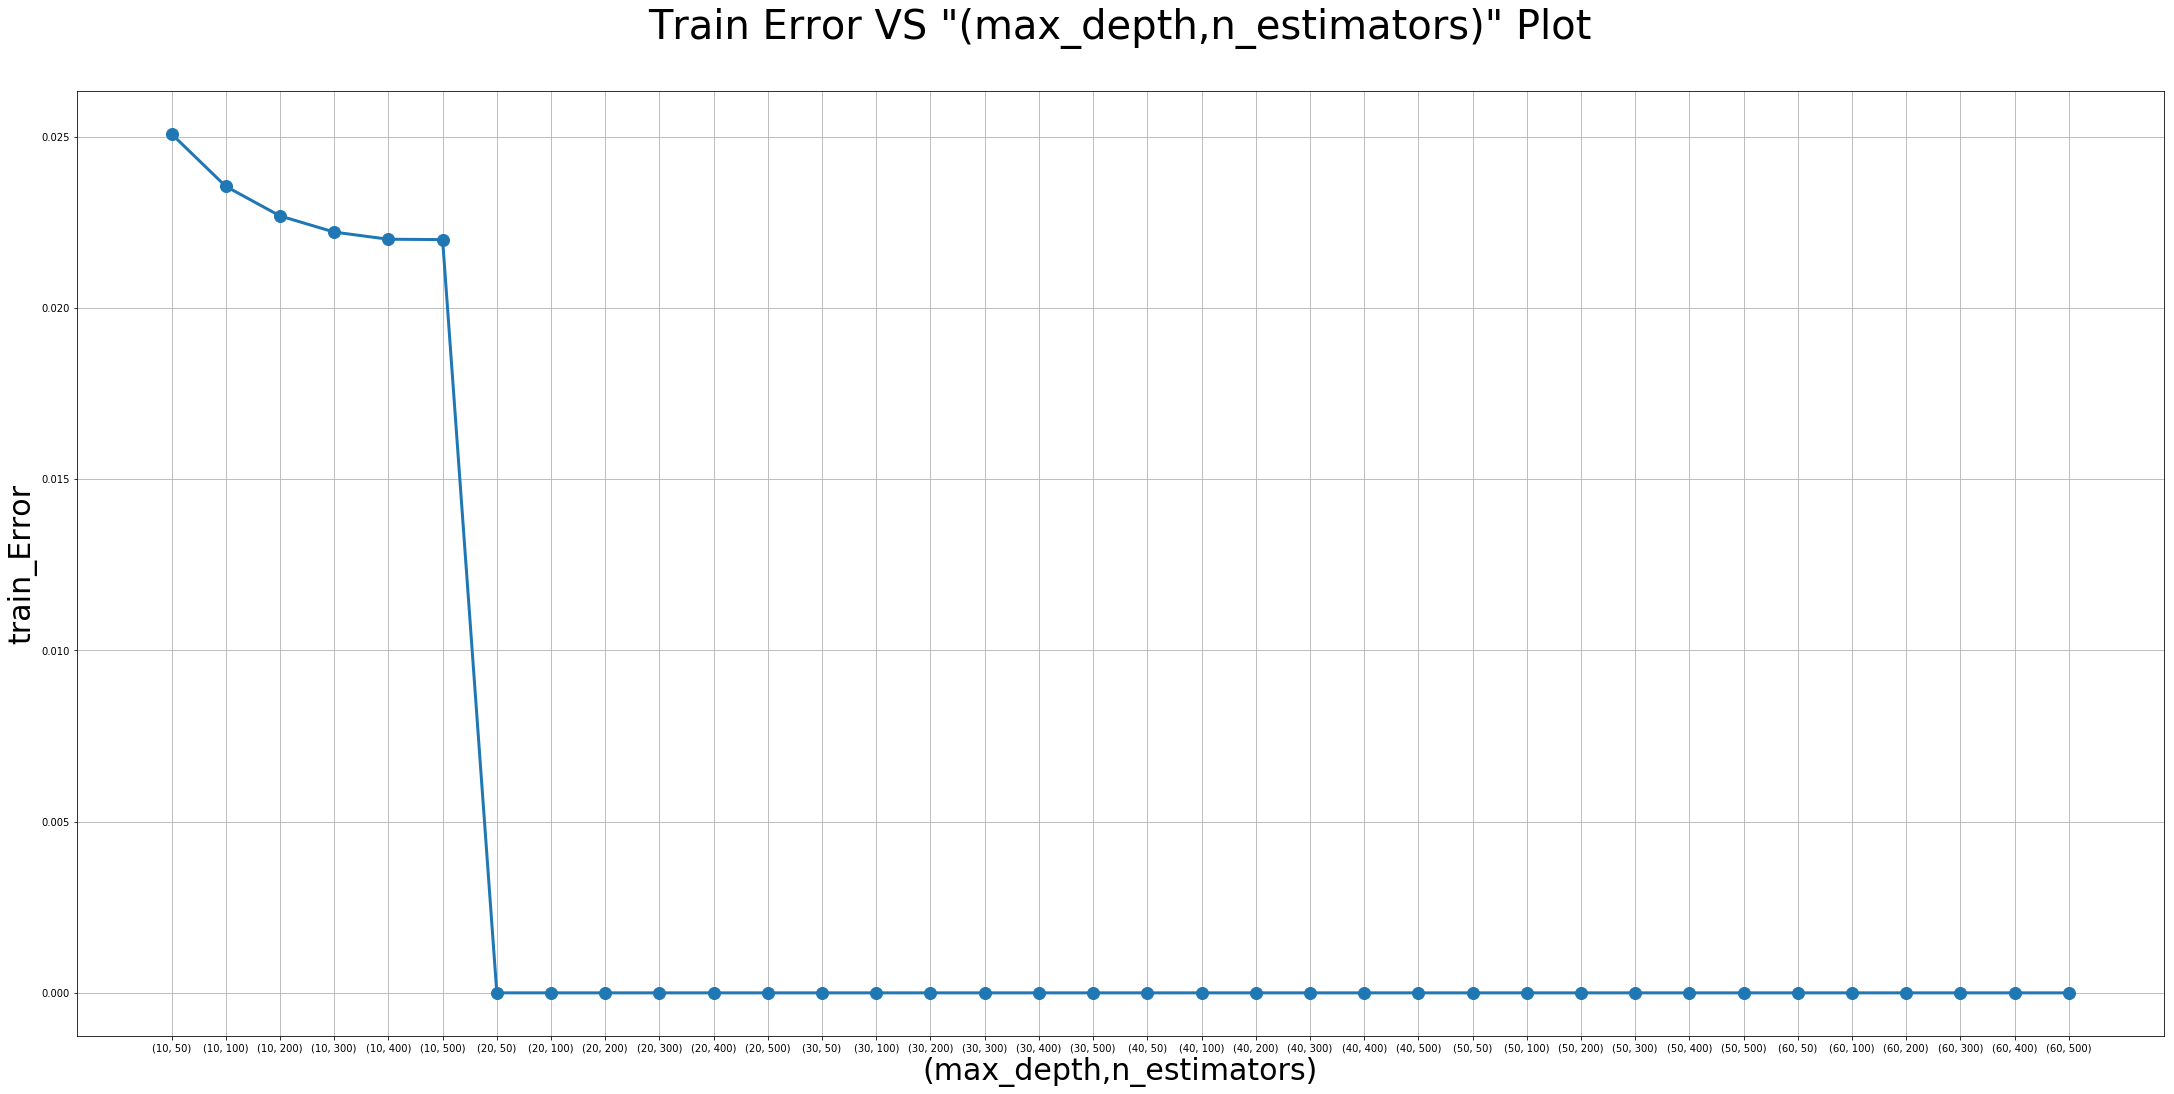

In [90]:
# Cross-Validation errors
cv_errors1 = [1-i for i in model_w2v.cv_results_['mean_train_score']]
# plotting Cross-Validation Error vs tuples of (max_depth,n_estimators) graph  
plt.figure(figsize=(30,15))
plt.plot(data, cv_errors1,linewidth=3, marker='o',markersize=12)
plt.xlabel('(max_depth,n_estimators)',size=30)
plt.ylabel('train_Error',size=30)
plt.title('Train Error VS "(max_depth,n_estimators)" Plot\n',size=40)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

Heatmap representation of AUC value of Max_depth & n_estimator on train data as follows:

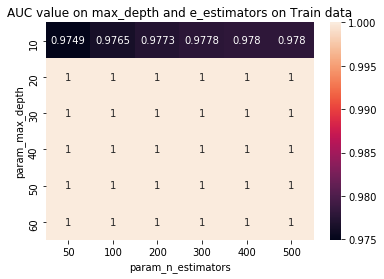

In [91]:
df_gridsearch1 = pd.DataFrame(model_w2v.cv_results_)
max_scores1 = df_gridsearch1.groupby(['param_max_depth','param_n_estimators']).max()
max_scores1 = max_scores1.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores1.mean_train_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on Train data')
plt.show()

Confusion Matrix of train data

In [94]:
pred_train= model_w2v.predict(sent_vectors_train)
cm = confusion_matrix(y_train, pred_train)
cm

array([[ 6764,    24],
       [    0, 42212]], dtype=int64)

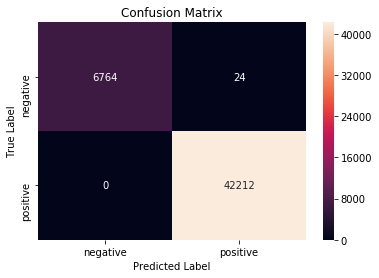

In [95]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Result on Test Data of AVG W2V

In [96]:
clf_w2v = RandomForestClassifier(n_estimators=500, max_depth=20, n_jobs=-1)
clf_w2v.fit(sent_vectors_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

ROC Curve of train data and test data as follows:

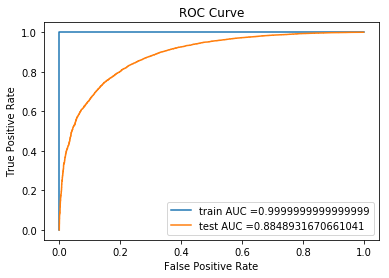

In [128]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_w2v.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_w2v.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

In [99]:
pred = clf_w2v.predict(sent_vectors_test)
pred_prob = clf_w2v.predict_proba(sent_vectors_test)[:,1]

print("AUC value on test data:",roc_auc_score(y_test, pred_prob))

AUC value on test data: 0.8848931670661041


Confusion Matrix of Test data as follows:

In [100]:
cm = confusion_matrix(y_test, pred)
cm

array([[ 1390,  3893],
       [  299, 24418]], dtype=int64)

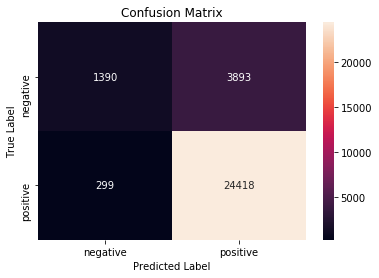

In [101]:
# plot confusion matrix to describe the performance of classifier.
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [102]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.82      0.26      0.40      5283
          1       0.86      0.99      0.92     24717

avg / total       0.86      0.86      0.83     30000



### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [103]:
tfw2v_train= np.array(tfidf_sent_vec_train)
tfw2v_train.shape

(49000, 50)

In [104]:
tfw2v_cv= np.array(tfidf_sent_vec_cv)
tfw2v_cv.shape

(21000, 50)

In [105]:
tfw2v_test= np.array(tfidf_sent_vec_test)
tfw2v_test.shape

(30000, 50)

In [106]:
#Hyperparameter tuning
estimators = [50,100,200,300,400,500]
Depths = [10,20,30,40,50,60]

param_grid = {'n_estimators': estimators, 'max_depth':Depths }
RFC = RandomForestClassifier()
model_tf_w2v = GridSearchCV(RFC, param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1,pre_dispatch=2)
model_tf_w2v.fit(tfw2v_train, y_train)

print("Model with best parameters :\n",model_tf_w2v.best_estimator_)
##Optimal value of max_depth
optimal_depth = model_tf_w2v.best_estimator_.max_depth
print("The optimal value of max depth of base model is : ",optimal_depth)

#Optimal value of n_estimators
optimal_estimator = model_tf_w2v.best_estimator_.n_estimators
print("The optimal value of n_estimator is : ",optimal_estimator)

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
The optimal value of max depth of base model is :  50
The optimal value of n_estimator is :  100


Graph representation of CV error v/s Max_depth & n_estimator on cv data of TFIDF W2V as follows:

In [107]:
# Cross-Validation errors
cv_errors = [1-i for i in model_tf_w2v.cv_results_['mean_test_score']]

arr_depth=model_tf_w2v.cv_results_['param_max_depth'] 
arr_estimator=model_tf_w2v.cv_results_['param_n_estimators']
data = [] #  List of tuples(depth,estimators)
for i in range(arr_depth.shape[0]):
    data.append(str((arr_depth[i],arr_estimator[i])))

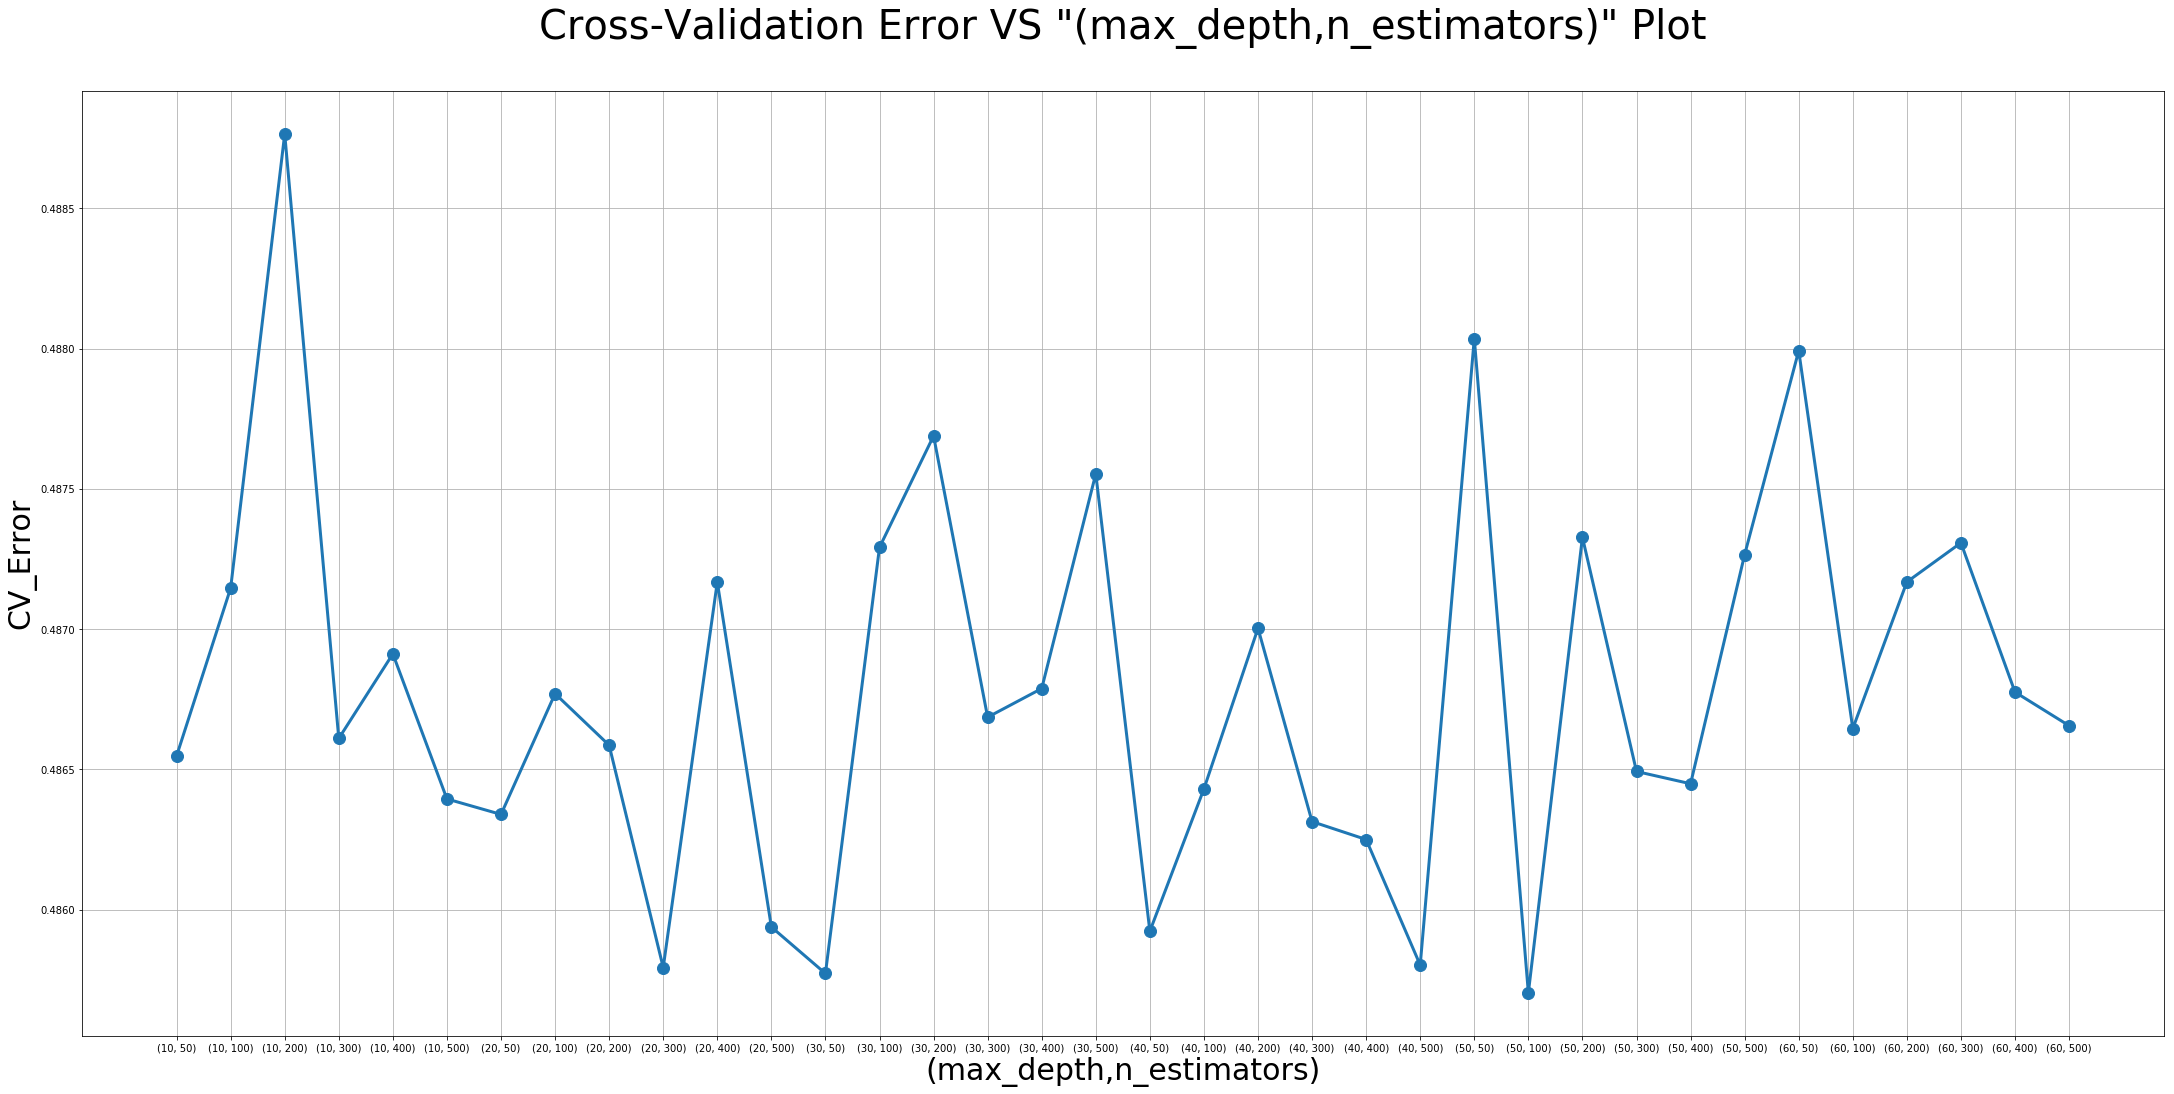

In [108]:
# plotting Cross-Validation Error vs tuples of (max_depth,n_estimators) graph  
plt.figure(figsize=(30,15))
plt.plot(data, cv_errors,linewidth=3, marker='o',markersize=12)
plt.xlabel('(max_depth,n_estimators)',size=30)
plt.ylabel('CV_Error',size=30)
plt.title('Cross-Validation Error VS "(max_depth,n_estimators)" Plot\n',size=40)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

Heatmap representation of AUC value of Max_depth & n_estimator on cv data as follows:

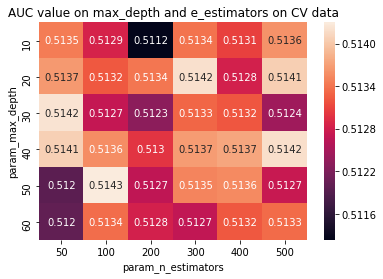

In [109]:
df_gridsearch = pd.DataFrame(model_tf_w2v.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on CV data')
plt.show()

Graph representation of CV error v/s Max_depth & n_estimator on train data as follows:

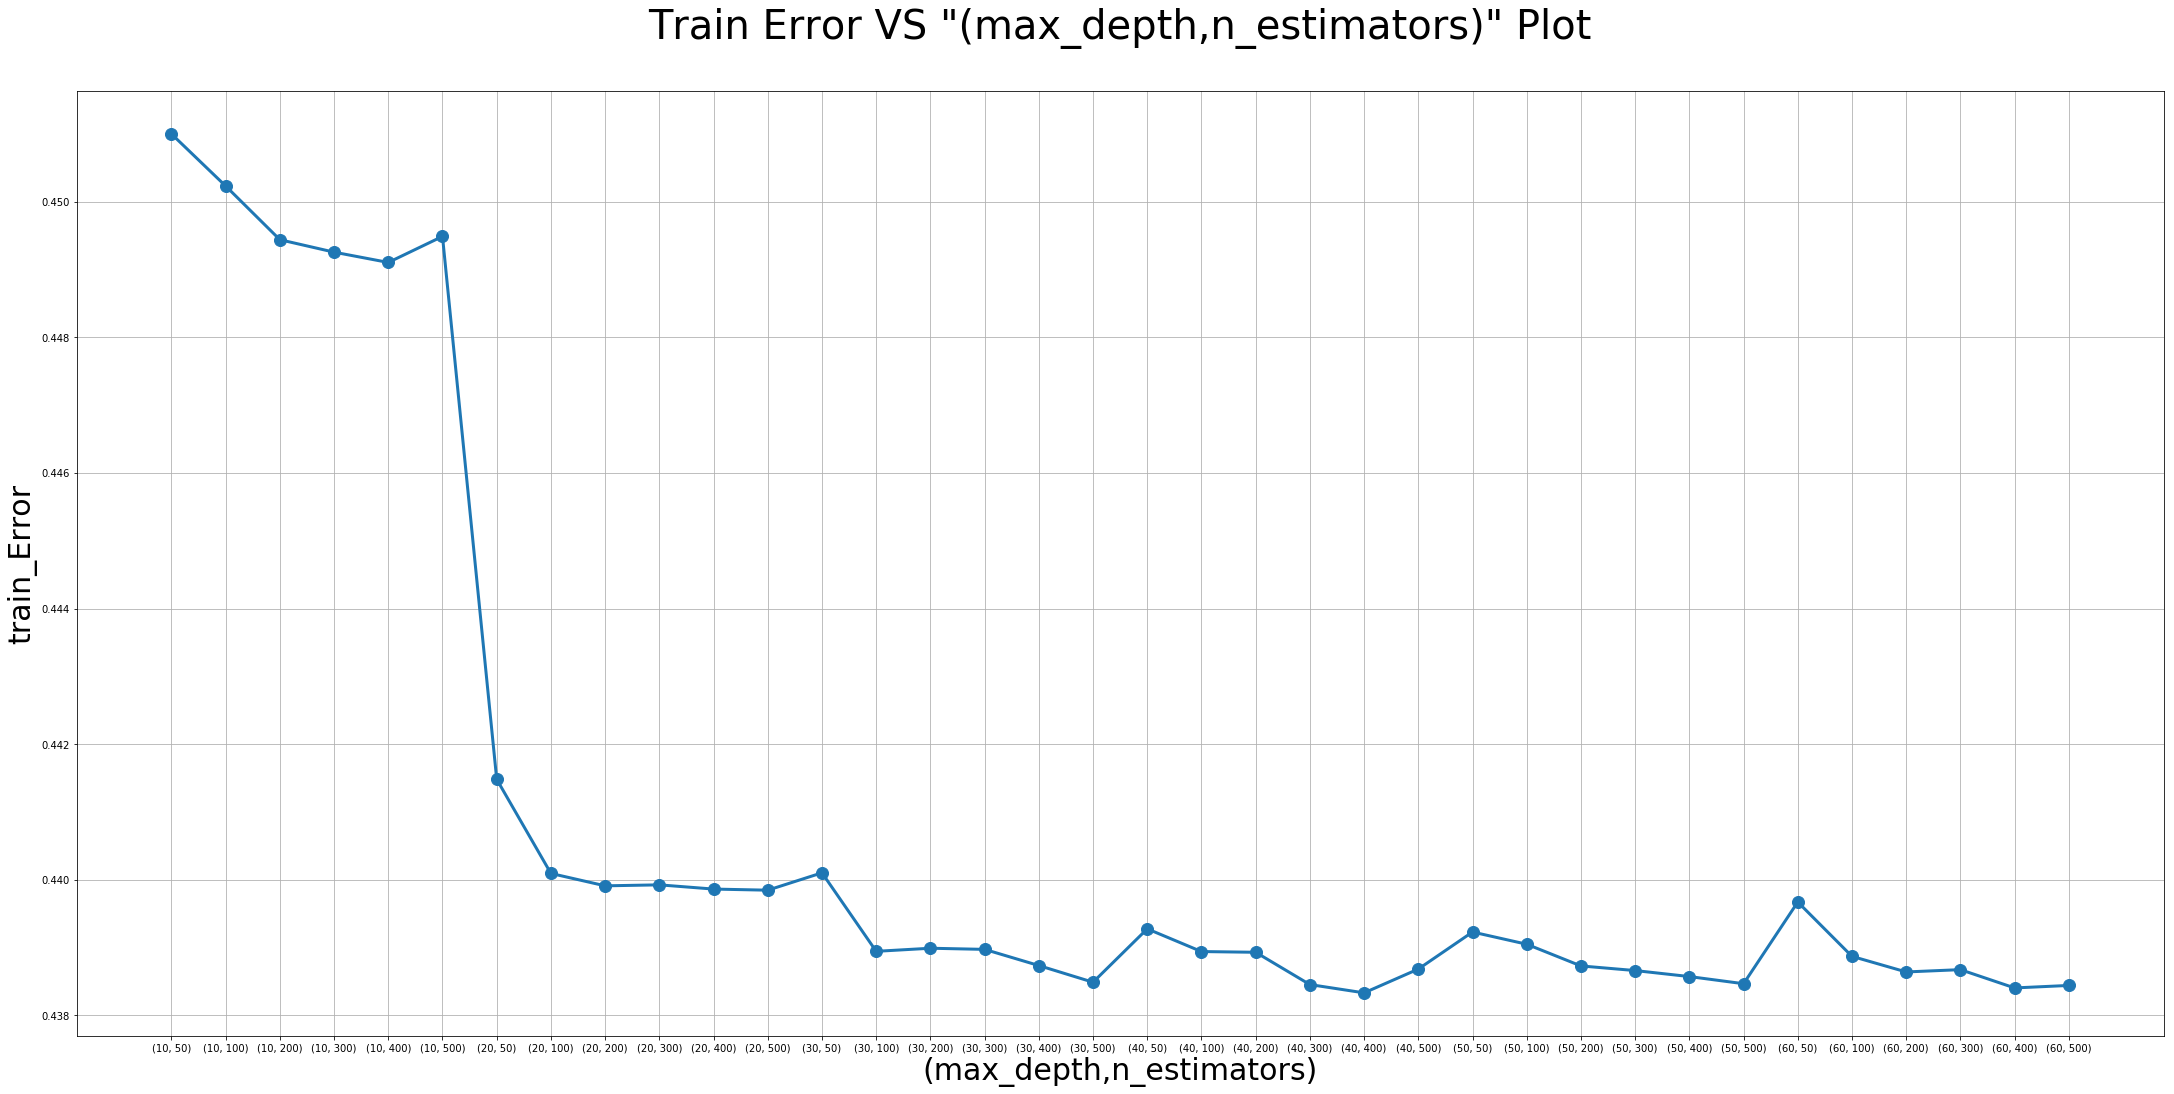

In [110]:
# Cross-Validation errors
cv_errors1 = [1-i for i in model_tf_w2v.cv_results_['mean_train_score']]
# plotting Cross-Validation Error vs tuples of (max_depth,n_estimators) graph  
plt.figure(figsize=(30,15))
plt.plot(data, cv_errors1,linewidth=3, marker='o',markersize=12)
plt.xlabel('(max_depth,n_estimators)',size=30)
plt.ylabel('train_Error',size=30)
plt.title('Train Error VS "(max_depth,n_estimators)" Plot\n',size=40)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

Heatmap representation of AUC value of Max_depth & n_estimator on train data as follows:

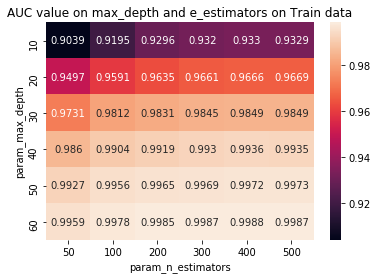

In [111]:
df_gridsearch1 = pd.DataFrame(model.cv_results_)
max_scores1 = df_gridsearch1.groupby(['param_max_depth','param_n_estimators']).max()
max_scores1 = max_scores1.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores1.mean_train_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on Train data')
plt.show()

Confusion Matrix of Train Data

In [116]:
pred_train= model_tf_w2v.predict(tfw2v_train)
cm = confusion_matrix(y_train, pred_train)
cm

array([[  277,  6511],
       [   10, 42202]], dtype=int64)

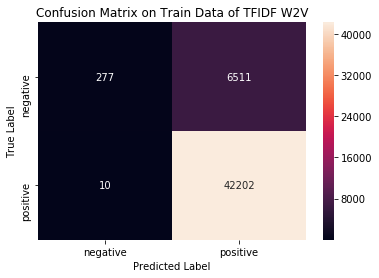

In [117]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix on Train Data of TFIDF W2V")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Result on Test Data of TFIDF W2V

In [118]:
clf_tf_w2v = RandomForestClassifier(n_estimators=100, max_depth=50, n_jobs=-1)
clf_tf_w2v.fit(tfw2v_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

ROC Curve of Train data and Test Data on optimal hyperparameters as follows:

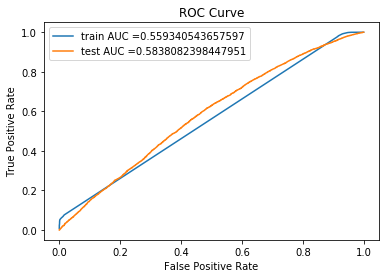

In [127]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_tf_w2v.predict_proba(tfw2v_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_tf_w2v.predict_proba(tfw2v_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

In [120]:
pred = clf_tf_w2v.predict(tfw2v_test)
pred_prob = clf_tf_w2v.predict_proba(tfw2v_test)[:,1]

print("AUC value on test data:",roc_auc_score(y_test, pred_prob))

AUC value on test data: 0.5838076348512751


Confusion Matrix of Test Data

In [121]:
cm = confusion_matrix(y_test, pred)
cm

array([[    0,  5283],
       [    0, 24717]], dtype=int64)

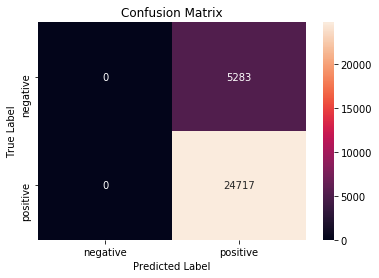

In [122]:
# plot confusion matrix to describe the performance of classifier.
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [125]:
# To show main classification report
print(classification_report(y_test, pred))

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00      5283
          1       0.82      1.00      0.90     24717

avg / total       0.68      0.82      0.74     30000



## [5.2] Applying GBDT using XGBOOST

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [133]:
%timeit
from xgboost import XGBClassifier

estimators = [50,100,200,300,400,500]
Depths = [3,5,7,9,11,13]

param_grid = {'n_estimators': estimators, 'max_depth':Depths }
XGB = XGBClassifier(booster='gbtree')
model_xgb1 = GridSearchCV(XGB, param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1,pre_dispatch=2)
model_xgb1.fit(bow_train, y_train)


print("Model with best parameters :\n",model_xgb1.best_estimator_)
##Optimal value of max_depth
optimal_depth = model_xgb1.best_estimator_.max_depth
print("The optimal value of max depth of base model is : ",optimal_depth)

#Optimal value of n_estimators
optimal_estimator = model_xgb1.best_estimator_.n_estimators
print("The optimal value of n_estimator is : ",optimal_estimator)
print("AUC value on Train data:", model_xgb1.best_score_)
print("AUC value on CV data:",model_xgb1.score(bow_cv, y_cv) )

Model with best parameters :
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
The optimal value of max depth of base model is :  9
The optimal value of n_estimator is :  500
AUC value on Train data: 0.9256619165309254
AUC value on CV data: 0.9355473087186356


Graph representation of CV error v/s Max_depth & n_estimator on cv data of BOW as follows:

In [134]:
# Cross-Validation errors
cv_errors = [1-i for i in model_xgb1.cv_results_['mean_test_score']]

arr_depth=model_xgb1.cv_results_['param_max_depth'] 
arr_estimator=model_xgb1.cv_results_['param_n_estimators']  
data = [] #  List of tuples(depth,estimators)
for i in range(arr_depth.shape[0]):
    data.append(str((arr_depth[i],arr_estimator[i])))

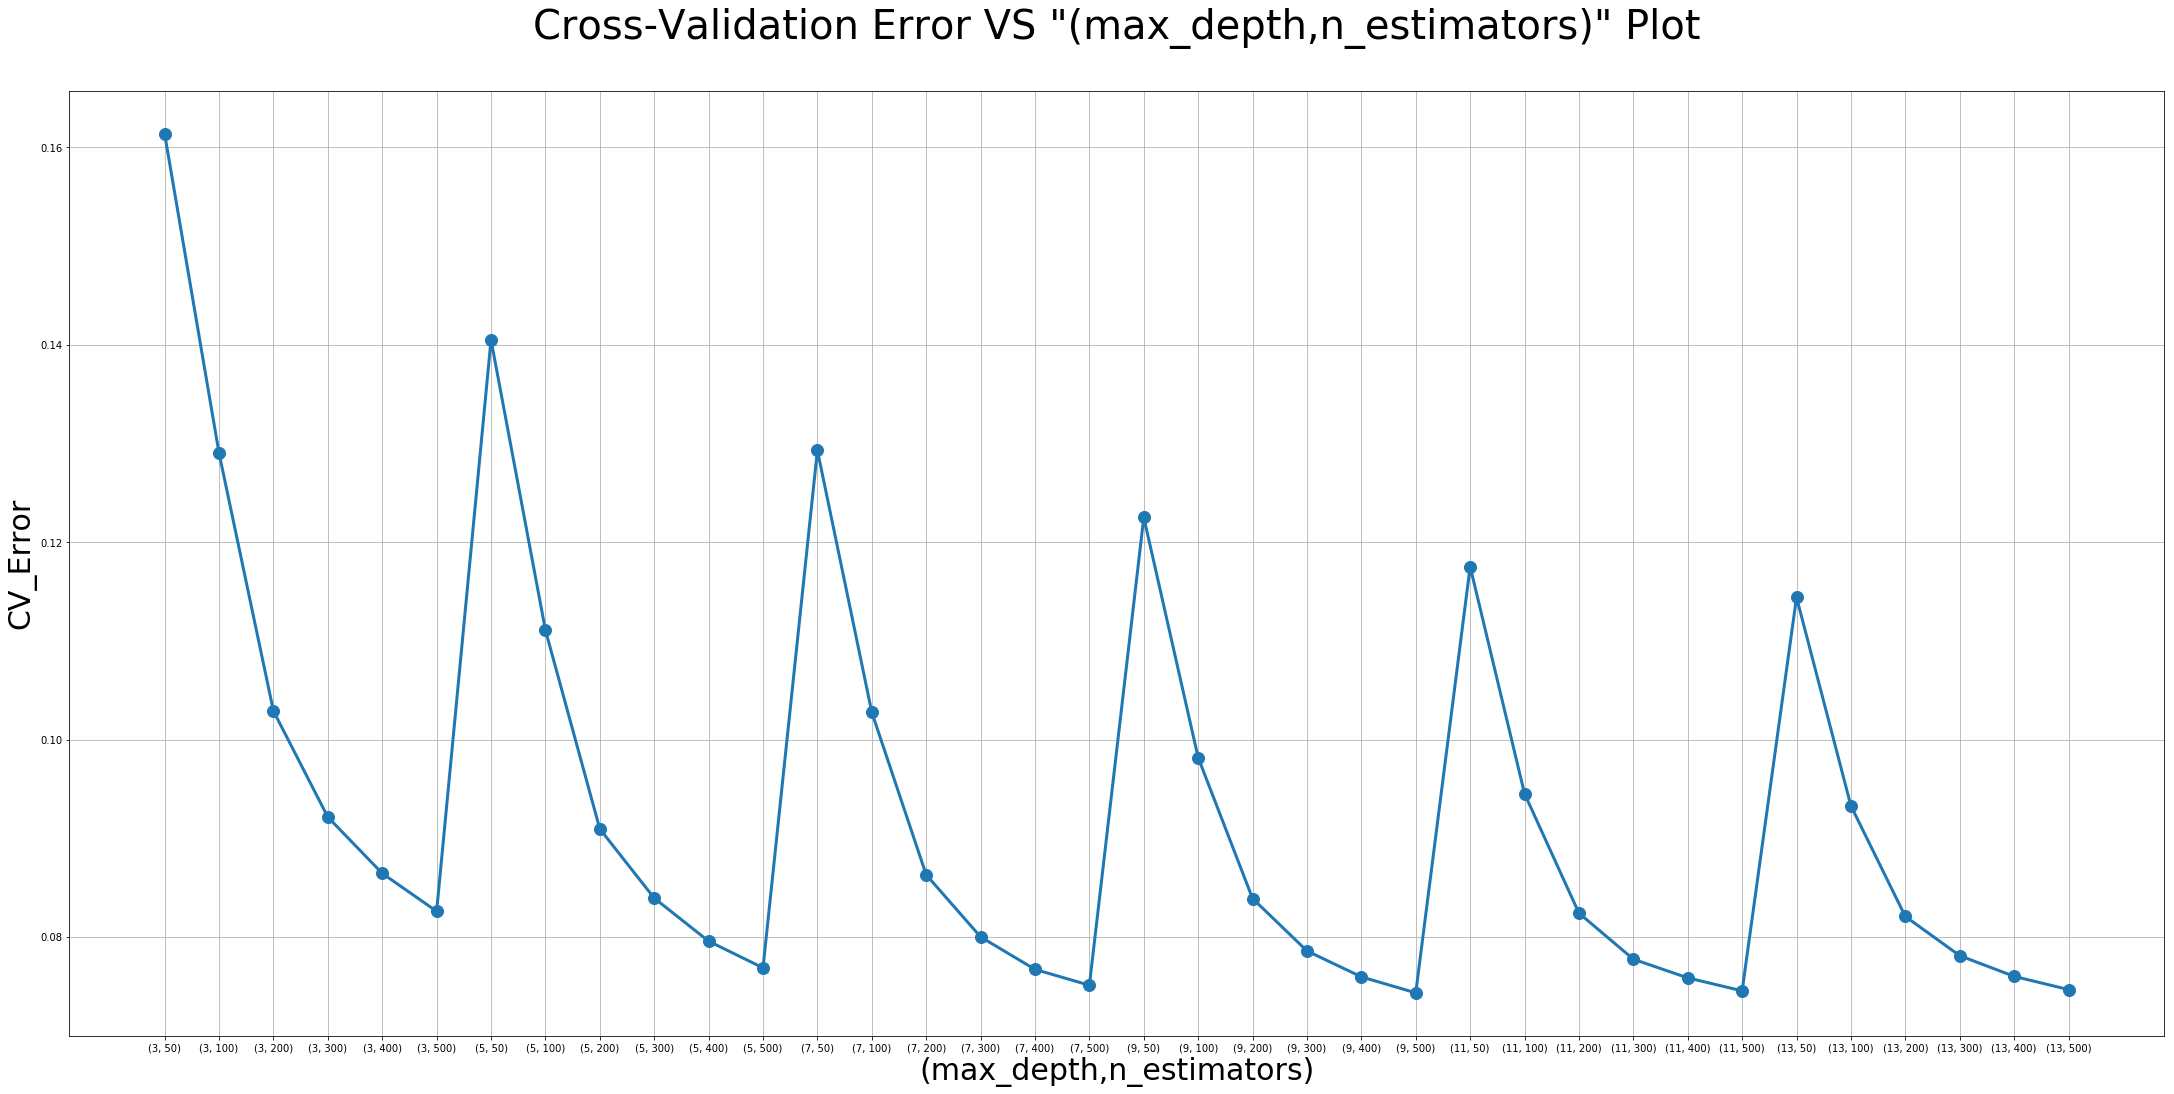

In [135]:
# plotting Cross-Validation Error vs tuples of (max_depth,n_estimators) graph  
plt.figure(figsize=(30,15))
plt.plot(data, cv_errors,linewidth=3, marker='o',markersize=12)
plt.xlabel('(max_depth,n_estimators)',size=30)
plt.ylabel('CV_Error',size=30)
plt.title('Cross-Validation Error VS "(max_depth,n_estimators)" Plot\n',size=40)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

Heatmap representation of AUC value of Max_depth & n_estimator on cv data as follows:

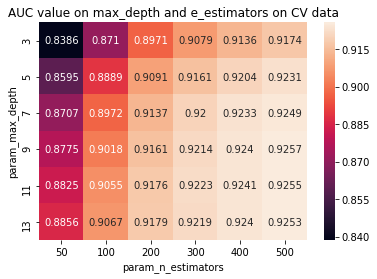

In [136]:
df_gridsearch = pd.DataFrame(model_xgb1.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on CV data')
plt.show()

Graph representation of CV error v/s Max_depth & n_estimator on train data of BOW as follows:

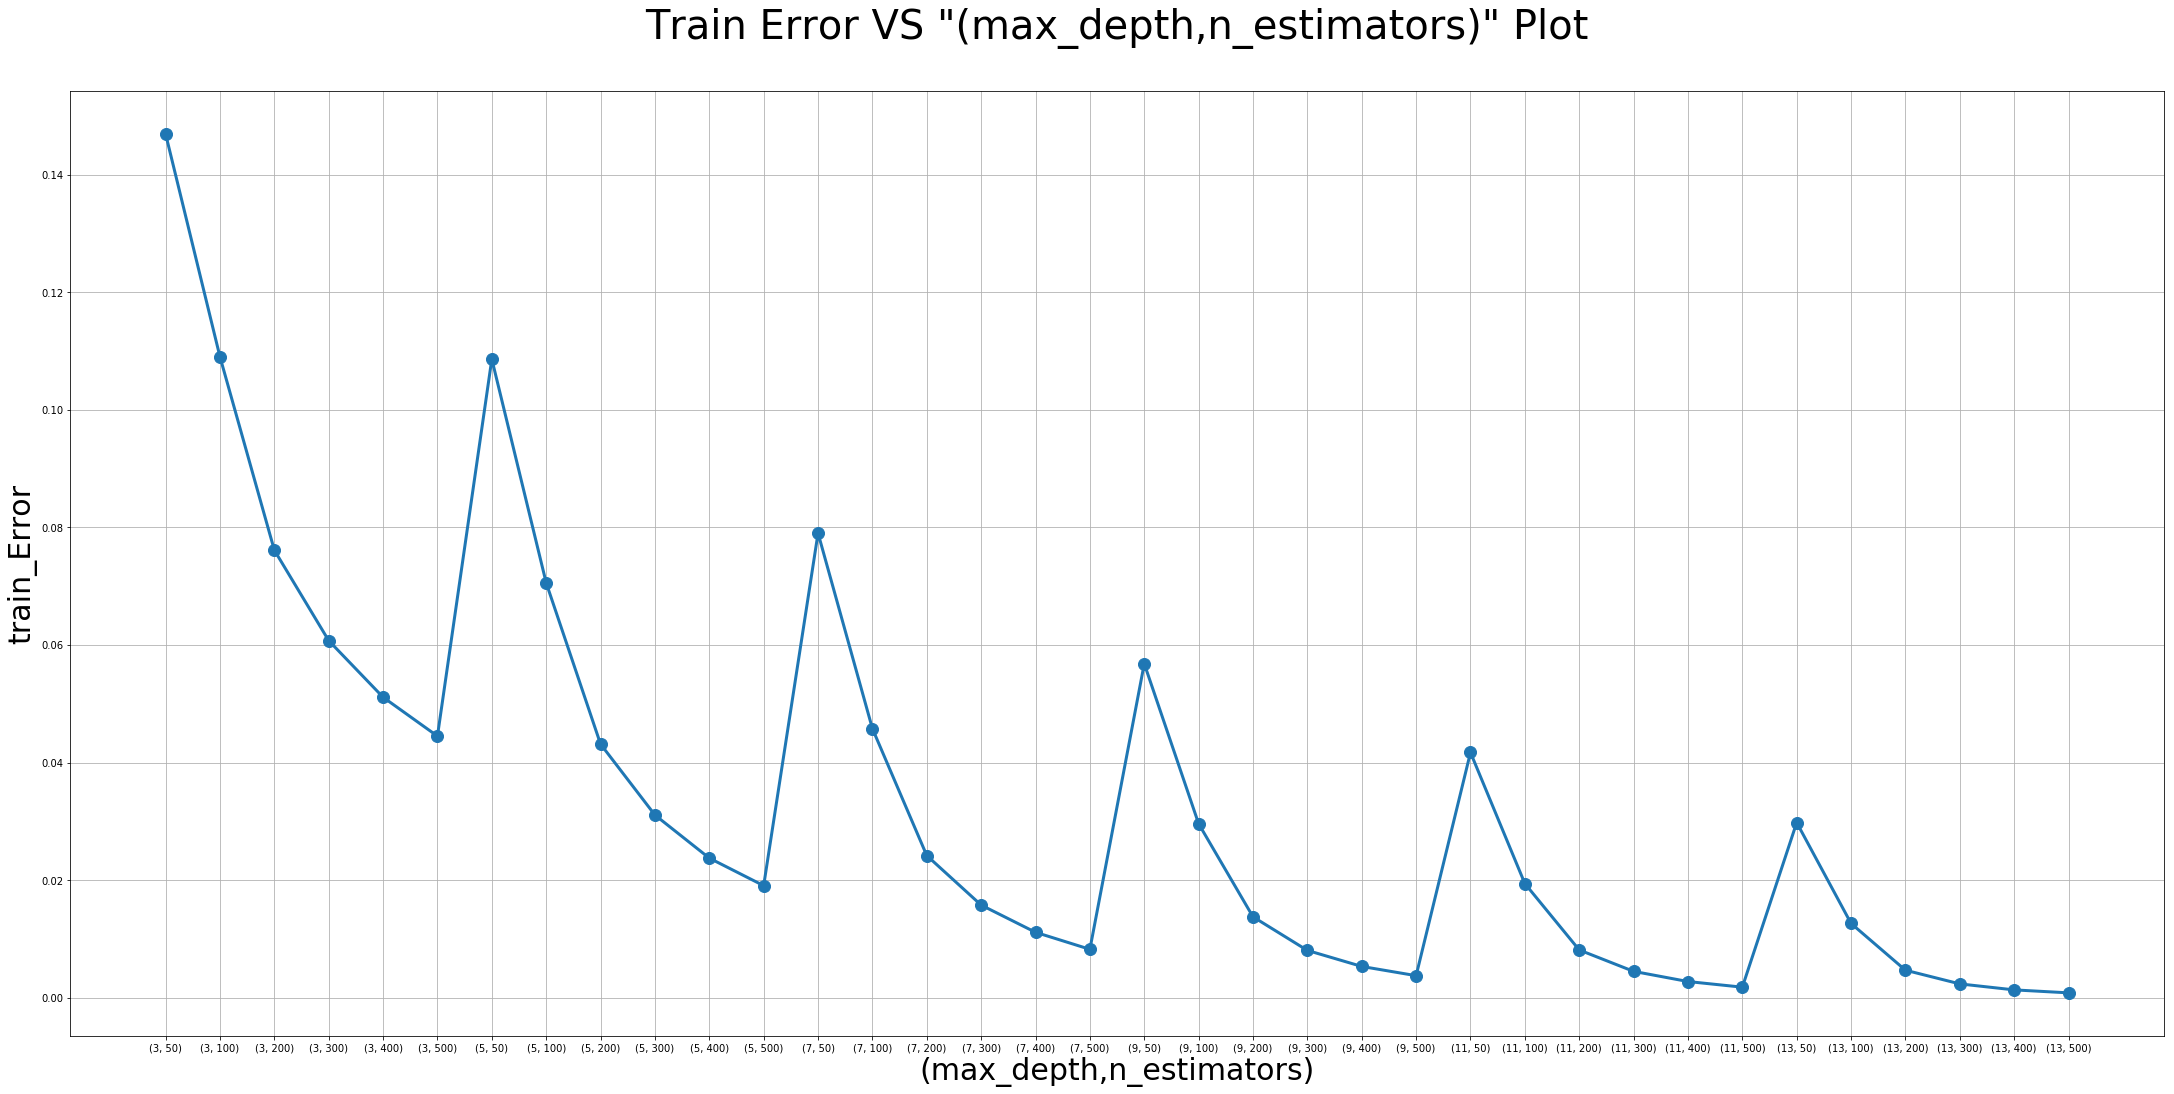

In [137]:
# Cross-Validation errors
cv_errors1 = [1-i for i in model_xgb1.cv_results_['mean_train_score']]
# plotting Cross-Validation Error vs tuples of (max_depth,n_estimators) graph  
plt.figure(figsize=(30,15))
plt.plot(data, cv_errors1,linewidth=3, marker='o',markersize=12)
plt.xlabel('(max_depth,n_estimators)',size=30)
plt.ylabel('train_Error',size=30)
plt.title('Train Error VS "(max_depth,n_estimators)" Plot\n',size=40)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

Heatmap representation of AUC value of Max_depth & n_estimator on train data as follows:

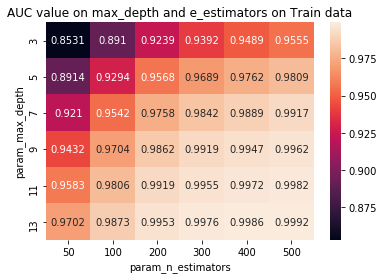

In [138]:
df_gridsearch1 = pd.DataFrame(model_xgb1.cv_results_)
max_scores1 = df_gridsearch1.groupby(['param_max_depth','param_n_estimators']).max()
max_scores1 = max_scores1.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores1.mean_train_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on Train data')
plt.show()

Confusion Matrix of Train Data

In [139]:
pred_train= model_xgb1.predict(bow_train)
cm = confusion_matrix(y_train, pred_train)
cm

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[ 5471,  1317],
       [   85, 42127]], dtype=int64)

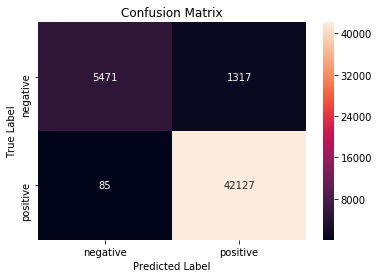

In [140]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Result on test data of BOW

In [141]:
clf = XGBClassifier(booster='gbtree',max_depth=9,n_estimators=500)
clf.fit(bow_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

ROC Curve of Train data and Test Data on fpr(false positive rate) and tpr(true positive rate) as follows:

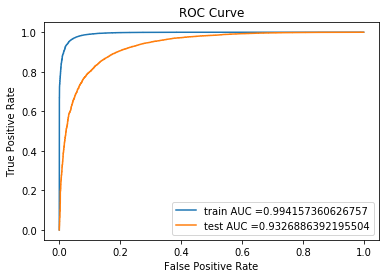

In [142]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(bow_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(bow_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

In [143]:
pred = clf.predict(bow_test)
pred_prob = clf.predict_proba(bow_test)[:,1]

print("AUC value on test data:",roc_auc_score(y_test, pred_prob))

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


AUC value on test data: 0.9326886392195504


Confusion Matrix on test data

In [144]:
cm = confusion_matrix(y_test, pred)
cm

array([[ 2828,  2455],
       [  466, 24251]], dtype=int64)

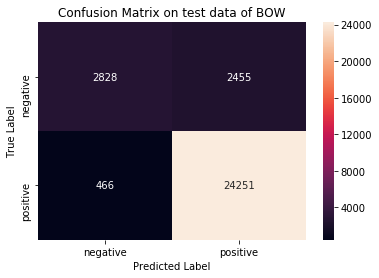

In [145]:
# plot confusion matrix to describe the performance of classifier.
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix on test data of BOW")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [146]:
# To show main classification report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.86      0.54      0.66      5283
          1       0.91      0.98      0.94     24717

avg / total       0.90      0.90      0.89     30000



### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [147]:
#Hyperparameter tuning
estimators = [50,100,200,300,400,500]
Depths = [3,5,7,9,11,13]

param_grid = {'n_estimators': estimators, 'max_depth':Depths }
XGB = XGBClassifier(booster='gbtree')
model_xgb2 = GridSearchCV(XGB, param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1,pre_dispatch=2)
model_xgb2.fit(tf_train, y_train)


print("Model with best parameters :\n",model_xgb2.best_estimator_)
##Optimal value of max_depth
optimal_depth = model_xgb2.best_estimator_.max_depth
print("The optimal value of max depth of base model is : ",optimal_depth)

#Optimal value of n_estimators
optimal_estimator = model_xgb2.best_estimator_.n_estimators
print("The optimal value of n_estimator is : ",optimal_estimator)
print("AUC value on Train data:", model_xgb2.best_score_)
print("AUC value on CV data:",model_xgb2.score(tf_cv, y_cv) )

Model with best parameters :
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=11, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
The optimal value of max depth of base model is :  11
The optimal value of n_estimator is :  500
AUC value on Train data: 0.9303919471834154
AUC value on CV data: 0.9405556549883826


Graph representation of CV error v/s Max_depth & n_estimator on cv data of TFIDF as follows:

In [151]:
# Cross-Validation errors
cv_errors = [1-i for i in model_xgb2.cv_results_['mean_test_score']]

arr_depth=model_xgb2.cv_results_['param_max_depth'] 
arr_estimator=model_xgb2.cv_results_['param_n_estimators']   
data = [] #  List of tuples(depth,estimators)
for i in range(arr_depth.shape[0]):
    data.append(str((arr_depth[i],arr_estimator[i])))

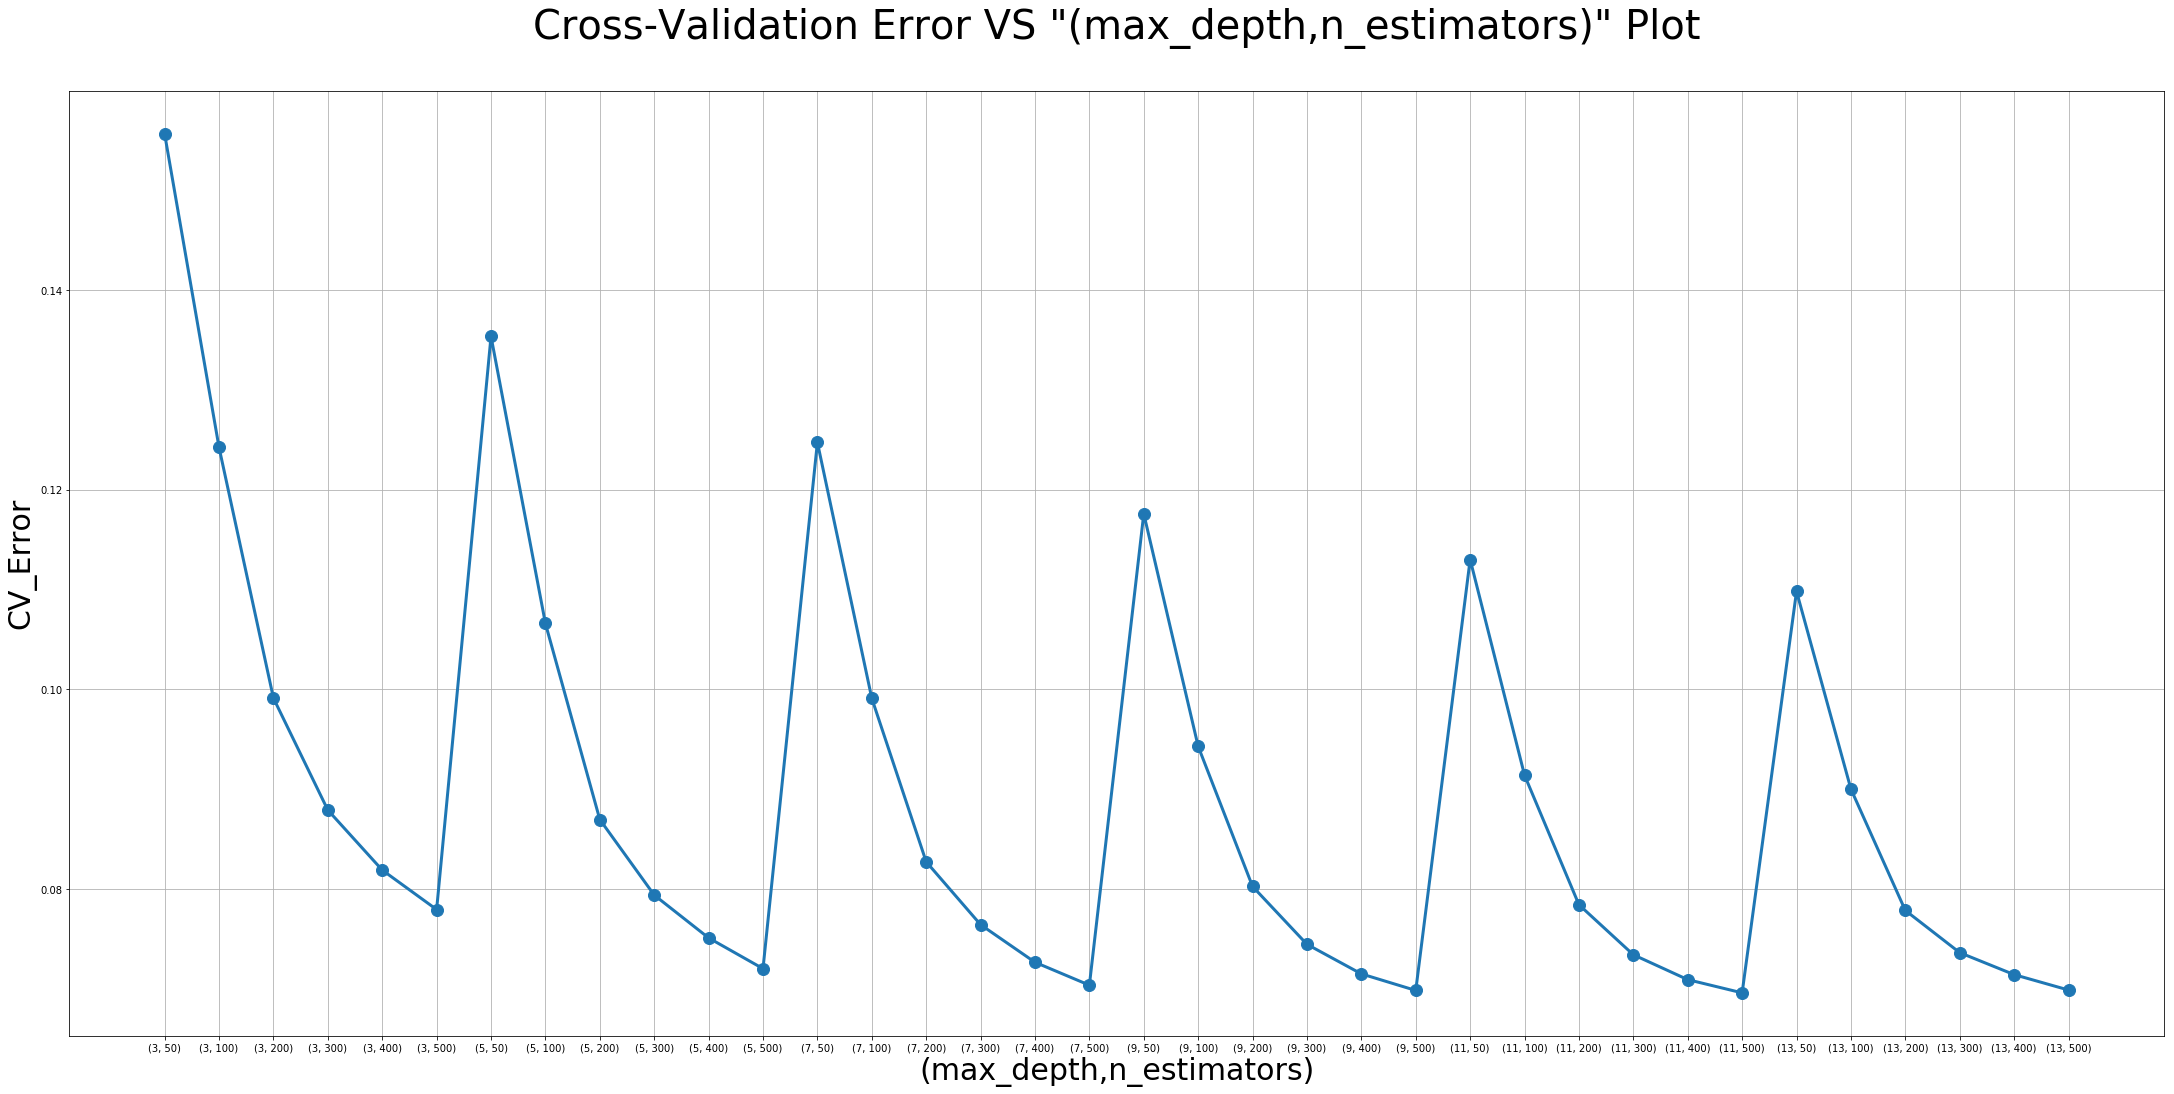

In [152]:
# plotting Cross-Validation Error vs tuples of (max_depth,n_estimators) graph  
plt.figure(figsize=(30,15))
plt.plot(data, cv_errors,linewidth=3, marker='o',markersize=12)
plt.xlabel('(max_depth,n_estimators)',size=30)
plt.ylabel('CV_Error',size=30)
plt.title('Cross-Validation Error VS "(max_depth,n_estimators)" Plot\n',size=40)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

Heatmap representation of AUC value of Max_depth & n_estimator on cv data as follows:

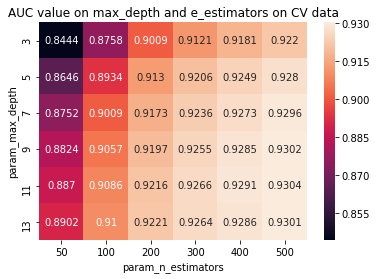

In [154]:
df_gridsearch = pd.DataFrame(model_xgb2.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on CV data')
plt.show()

Graph representation of CV error v/s Max_depth & n_estimator on train data of TFIDF as follows:

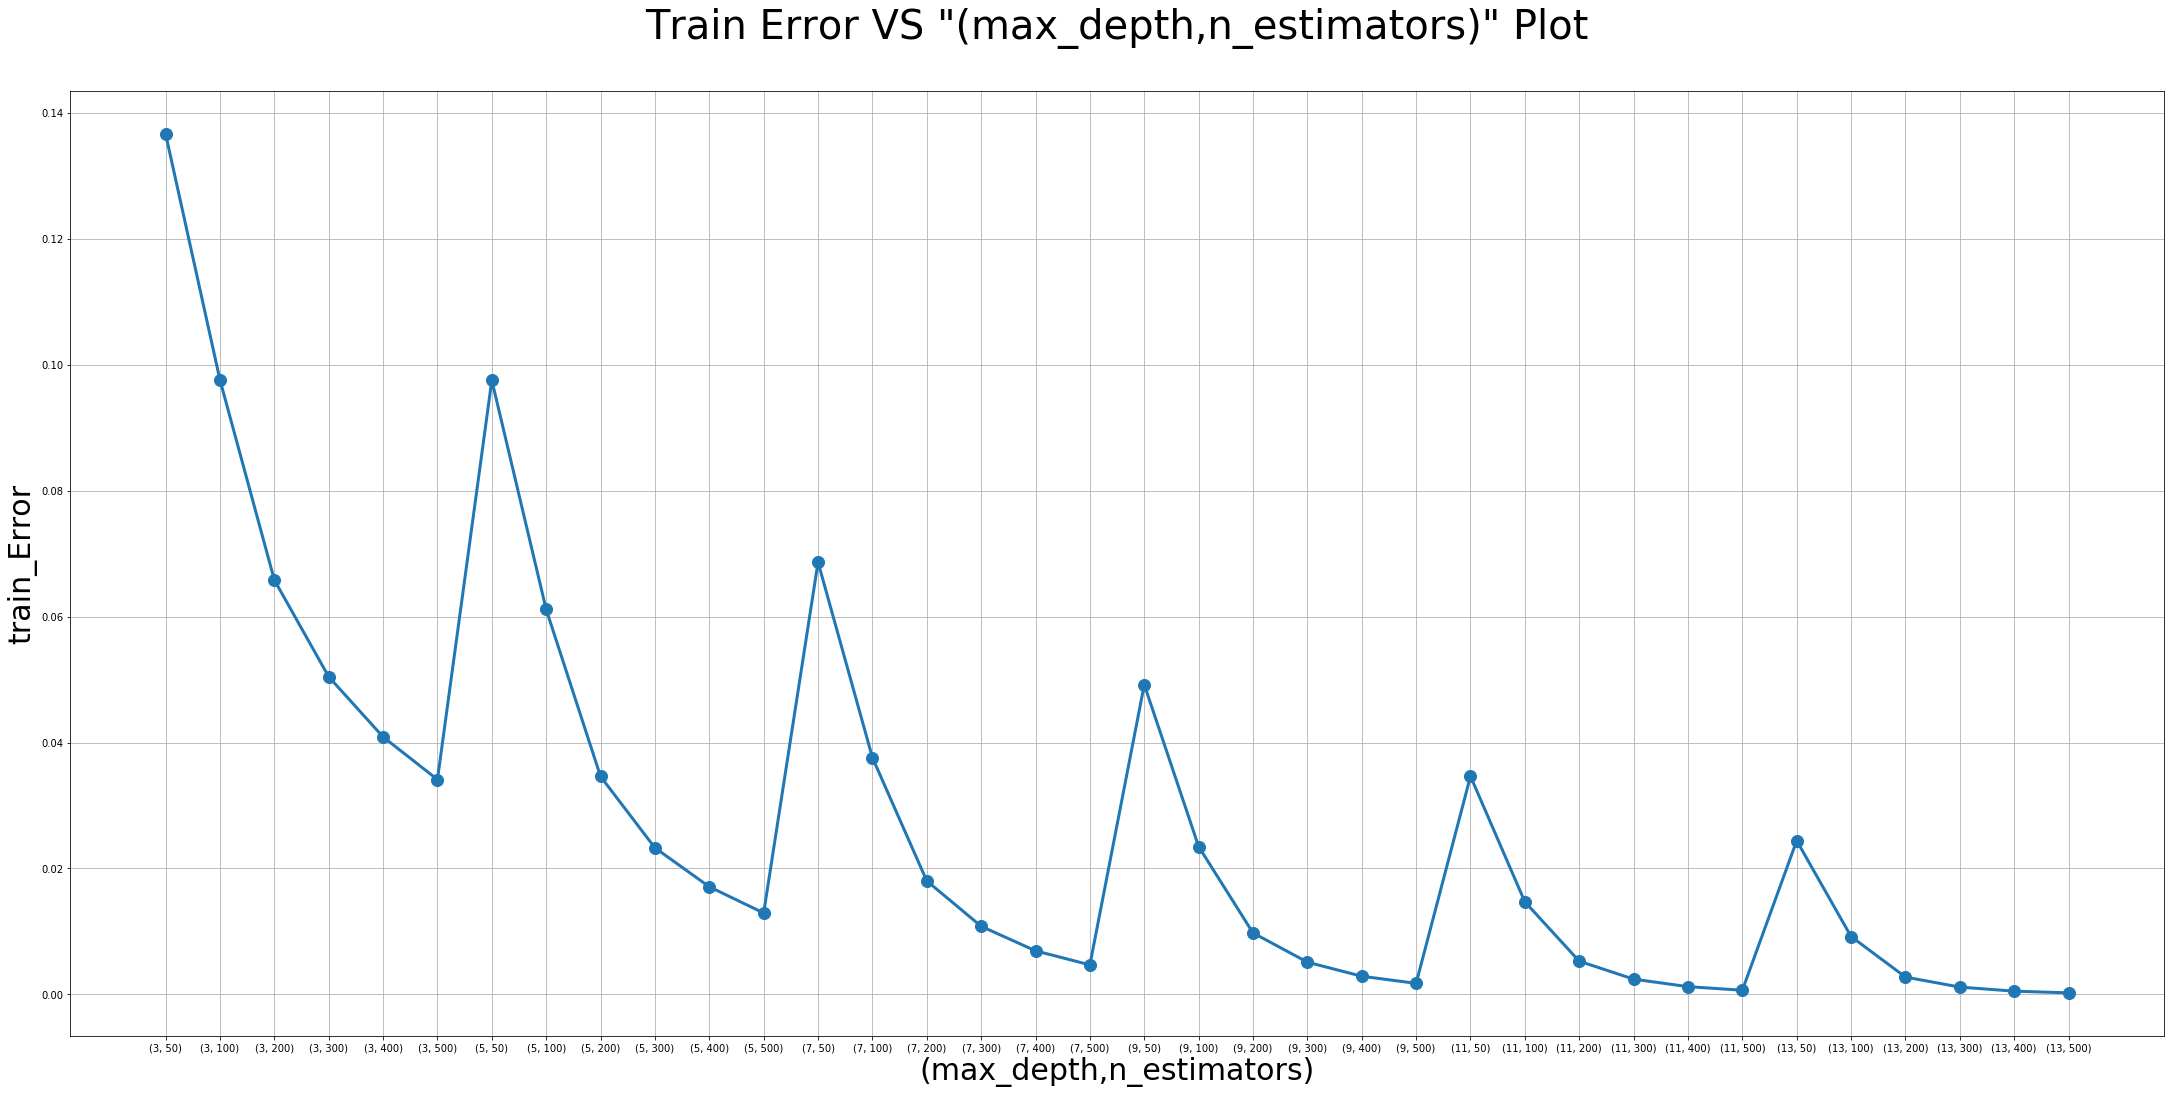

In [155]:
# Cross-Validation errors
cv_errors1 = [1-i for i in model_xgb2.cv_results_['mean_train_score']]
# plotting Cross-Validation Error vs tuples of (max_depth,n_estimators) graph  
plt.figure(figsize=(30,15))
plt.plot(data, cv_errors1,linewidth=3, marker='o',markersize=12)
plt.xlabel('(max_depth,n_estimators)',size=30)
plt.ylabel('train_Error',size=30)
plt.title('Train Error VS "(max_depth,n_estimators)" Plot\n',size=40)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()


Heatmap representation of AUC value of Max_depth & n_estimator on train data as follows:

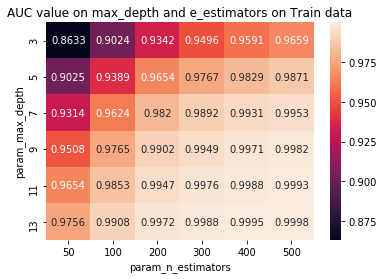

In [156]:
df_gridsearch1 = pd.DataFrame(model_xgb2.cv_results_)
max_scores1 = df_gridsearch1.groupby(['param_max_depth','param_n_estimators']).max()
max_scores1 = max_scores1.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores1.mean_train_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on Train data')
plt.show()

Confusion Matrix of train data as follows:

In [157]:
pred_train= model_xgb2.predict(tf_train)
cm = confusion_matrix(y_train, pred_train)
cm

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[ 6048,   740],
       [   39, 42173]], dtype=int64)

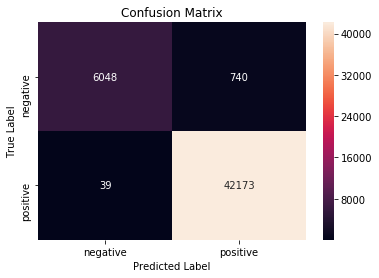

In [158]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Result on Test Data of TFIDF

In [159]:
clf_2 = XGBClassifier(booster='gbtree',max_depth=11,n_estimators=500)
clf_2.fit(tf_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=11, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

ROC Curve of Train data and Test Data on fpr(false positive rate) and tpr(true positive rate) as follows:

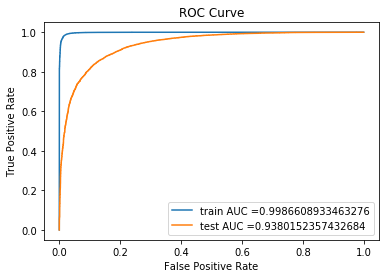

In [160]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_2.predict_proba(tf_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_2.predict_proba(tf_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

In [161]:
pred = clf_2.predict(tf_test)
pred_prob = clf_2.predict_proba(tf_test)[:,1]

print("AUC value on test data:",roc_auc_score(y_test, pred_prob))

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


AUC value on test data: 0.9380152357432684


Confusion Matrix of Test DATA as follows:

In [162]:
cm = confusion_matrix(y_test, pred)
cm

array([[ 2853,  2430],
       [  441, 24276]], dtype=int64)

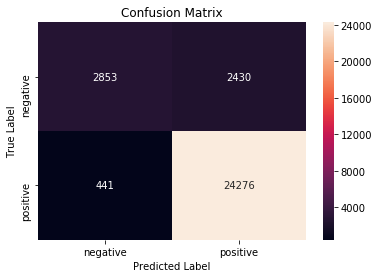

In [163]:
# plot confusion matrix to describe the performance of classifier.
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [164]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.87      0.54      0.67      5283
          1       0.91      0.98      0.94     24717

avg / total       0.90      0.90      0.90     30000



### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [149]:
avgw2v_train= np.array(sent_vectors_train)
print(avgw2v_train.shape)
avgw2v_cv= np.array(sent_vectors_cv)
print(avgw2v_cv.shape)
avgw2v_test= np.array(sent_vectors_test)
print(avgw2v_test.shape)

(49000, 50)
(21000, 50)
(30000, 50)


In [150]:
#Hyperparameter tuning
estimators = [50,100,200,300,400,500]
Depths = [3,5,7,9,11,13]

param_grid = {'n_estimators': estimators, 'max_depth':Depths }
XGB = XGBClassifier(booster='gbtree')
model_xgb3 = GridSearchCV(XGB, param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1,pre_dispatch=2)
model_xgb3.fit(avgw2v_train, y_train)


print("Model with best parameters :\n",model_xgb3.best_estimator_)
##Optimal value of max_depth
optimal_depth = model_xgb3.best_estimator_.max_depth
print("The optimal value of max depth of base model is : ",optimal_depth)

#Optimal value of n_estimators
optimal_estimator = model_xgb3.best_estimator_.n_estimators
print("The optimal value of n_estimator is : ",optimal_estimator)
print("AUC value on Train data:", model_xgb3.best_score_)
print("AUC value on CV data:",model_xgb3.score(avgw2v_cv, y_cv))

Model with best parameters :
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=13, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
The optimal value of max depth of base model is :  13
The optimal value of n_estimator is :  500
AUC value on Train data: 0.9004819375713028
AUC value on CV data: 0.909066585497012


Graph representation of CV error v/s Max_depth & n_estimator on CV data of AVG W2V as follows:

In [165]:
# Cross-Validation errors
cv_errors = [1-i for i in model_xgb3.cv_results_['mean_test_score']]

arr_depth=model_xgb3.cv_results_['param_max_depth'] 
arr_estimator=model_xgb3.cv_results_['param_n_estimators'] 
data = [] #  List of tuples(depth,estimators)
for i in range(arr_depth.shape[0]):
    data.append(str((arr_depth[i],arr_estimator[i])))

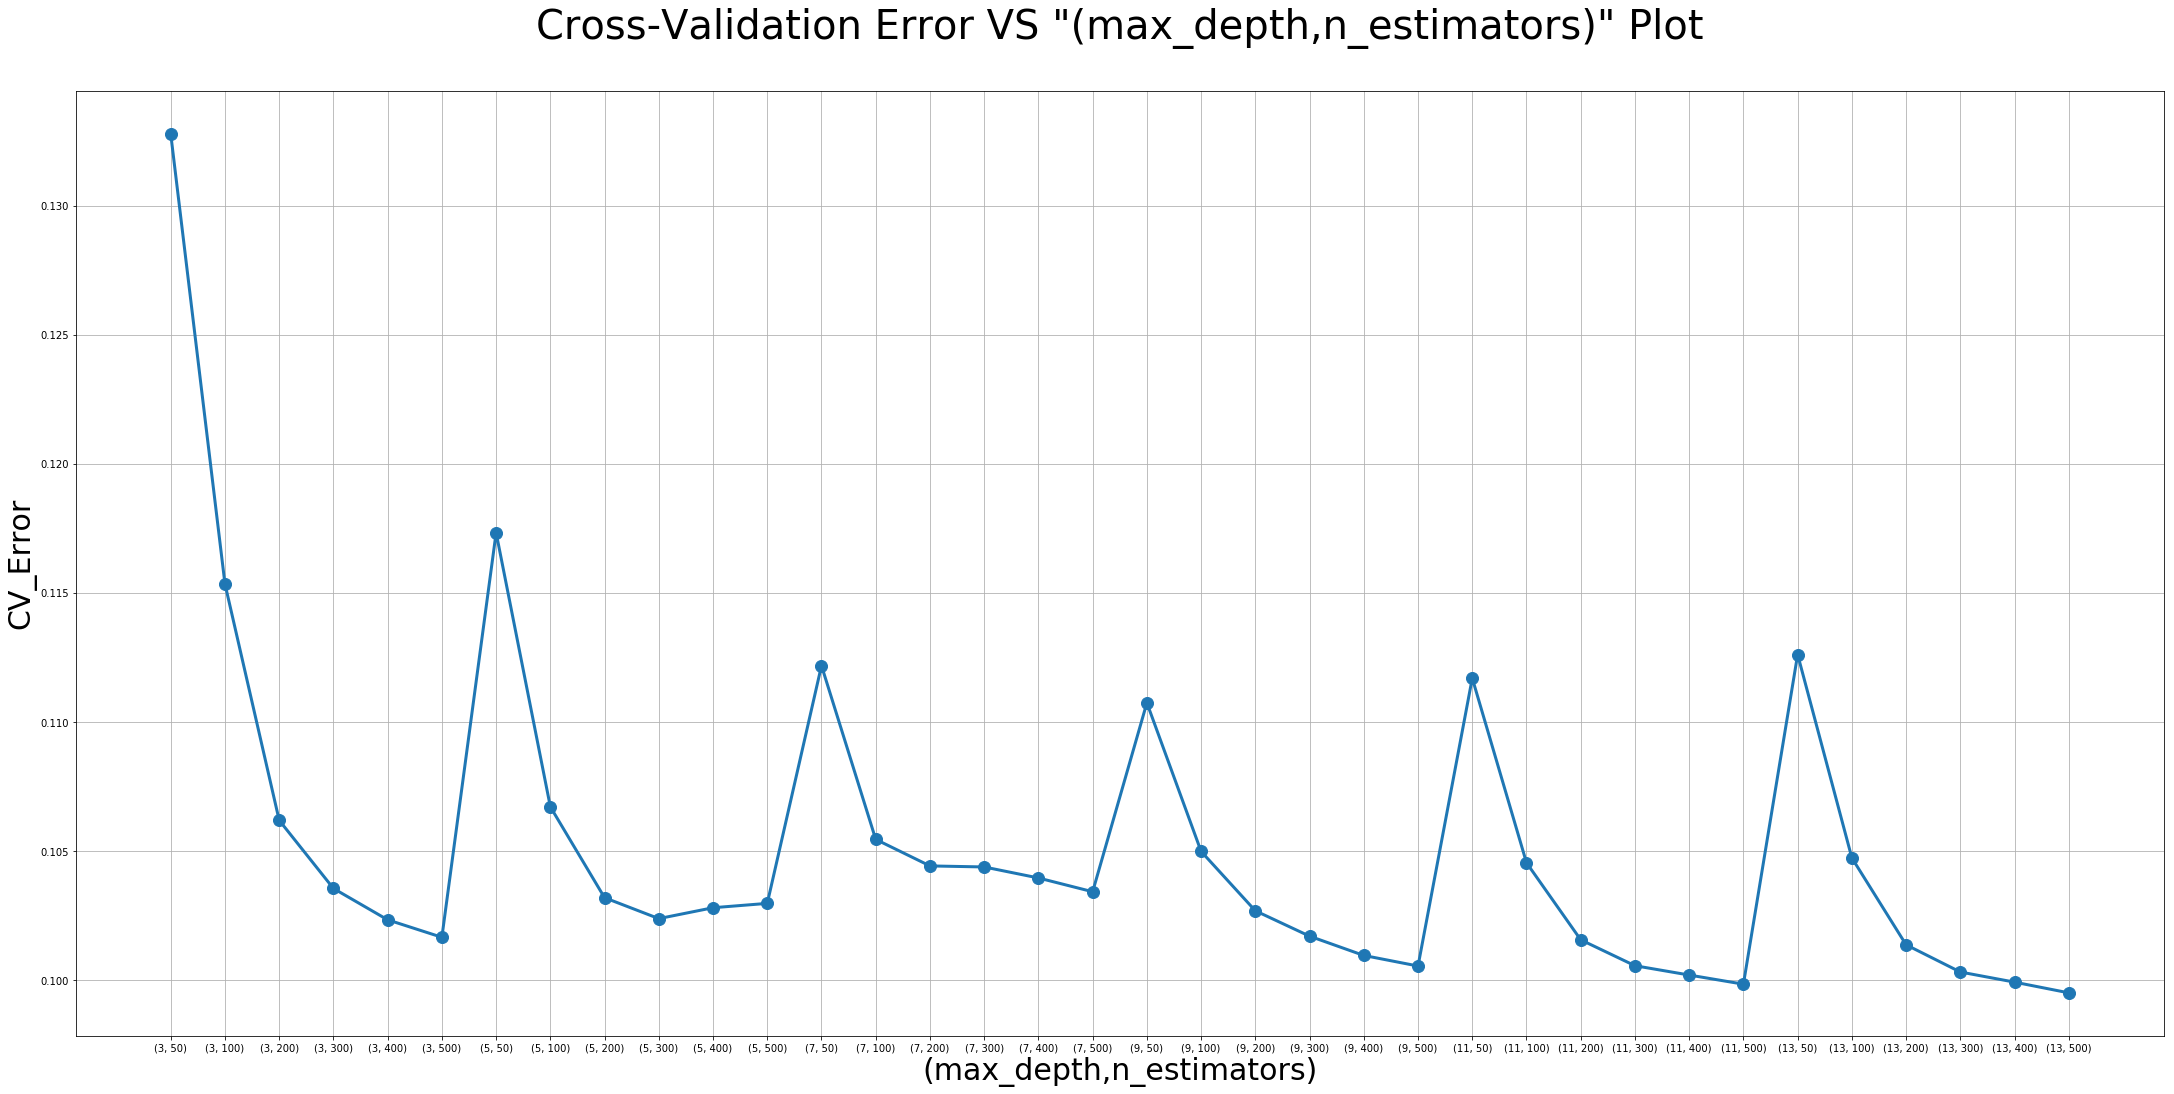

In [166]:
# plotting Cross-Validation Error vs tuples of (max_depth,n_estimators) graph  
plt.figure(figsize=(30,15))
plt.plot(data, cv_errors,linewidth=3, marker='o',markersize=12)
plt.xlabel('(max_depth,n_estimators)',size=30)
plt.ylabel('CV_Error',size=30)
plt.title('Cross-Validation Error VS "(max_depth,n_estimators)" Plot\n',size=40)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

Heatmap representation of AUC value of Max_depth & n_estimator on cv data as follows:

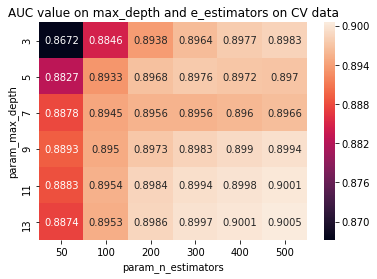

In [167]:
df_gridsearch = pd.DataFrame(model_xgb3.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on CV data')
plt.show()

Graph representation of CV error v/s Max_depth & n_estimator on train data of AVG W2V as follows:

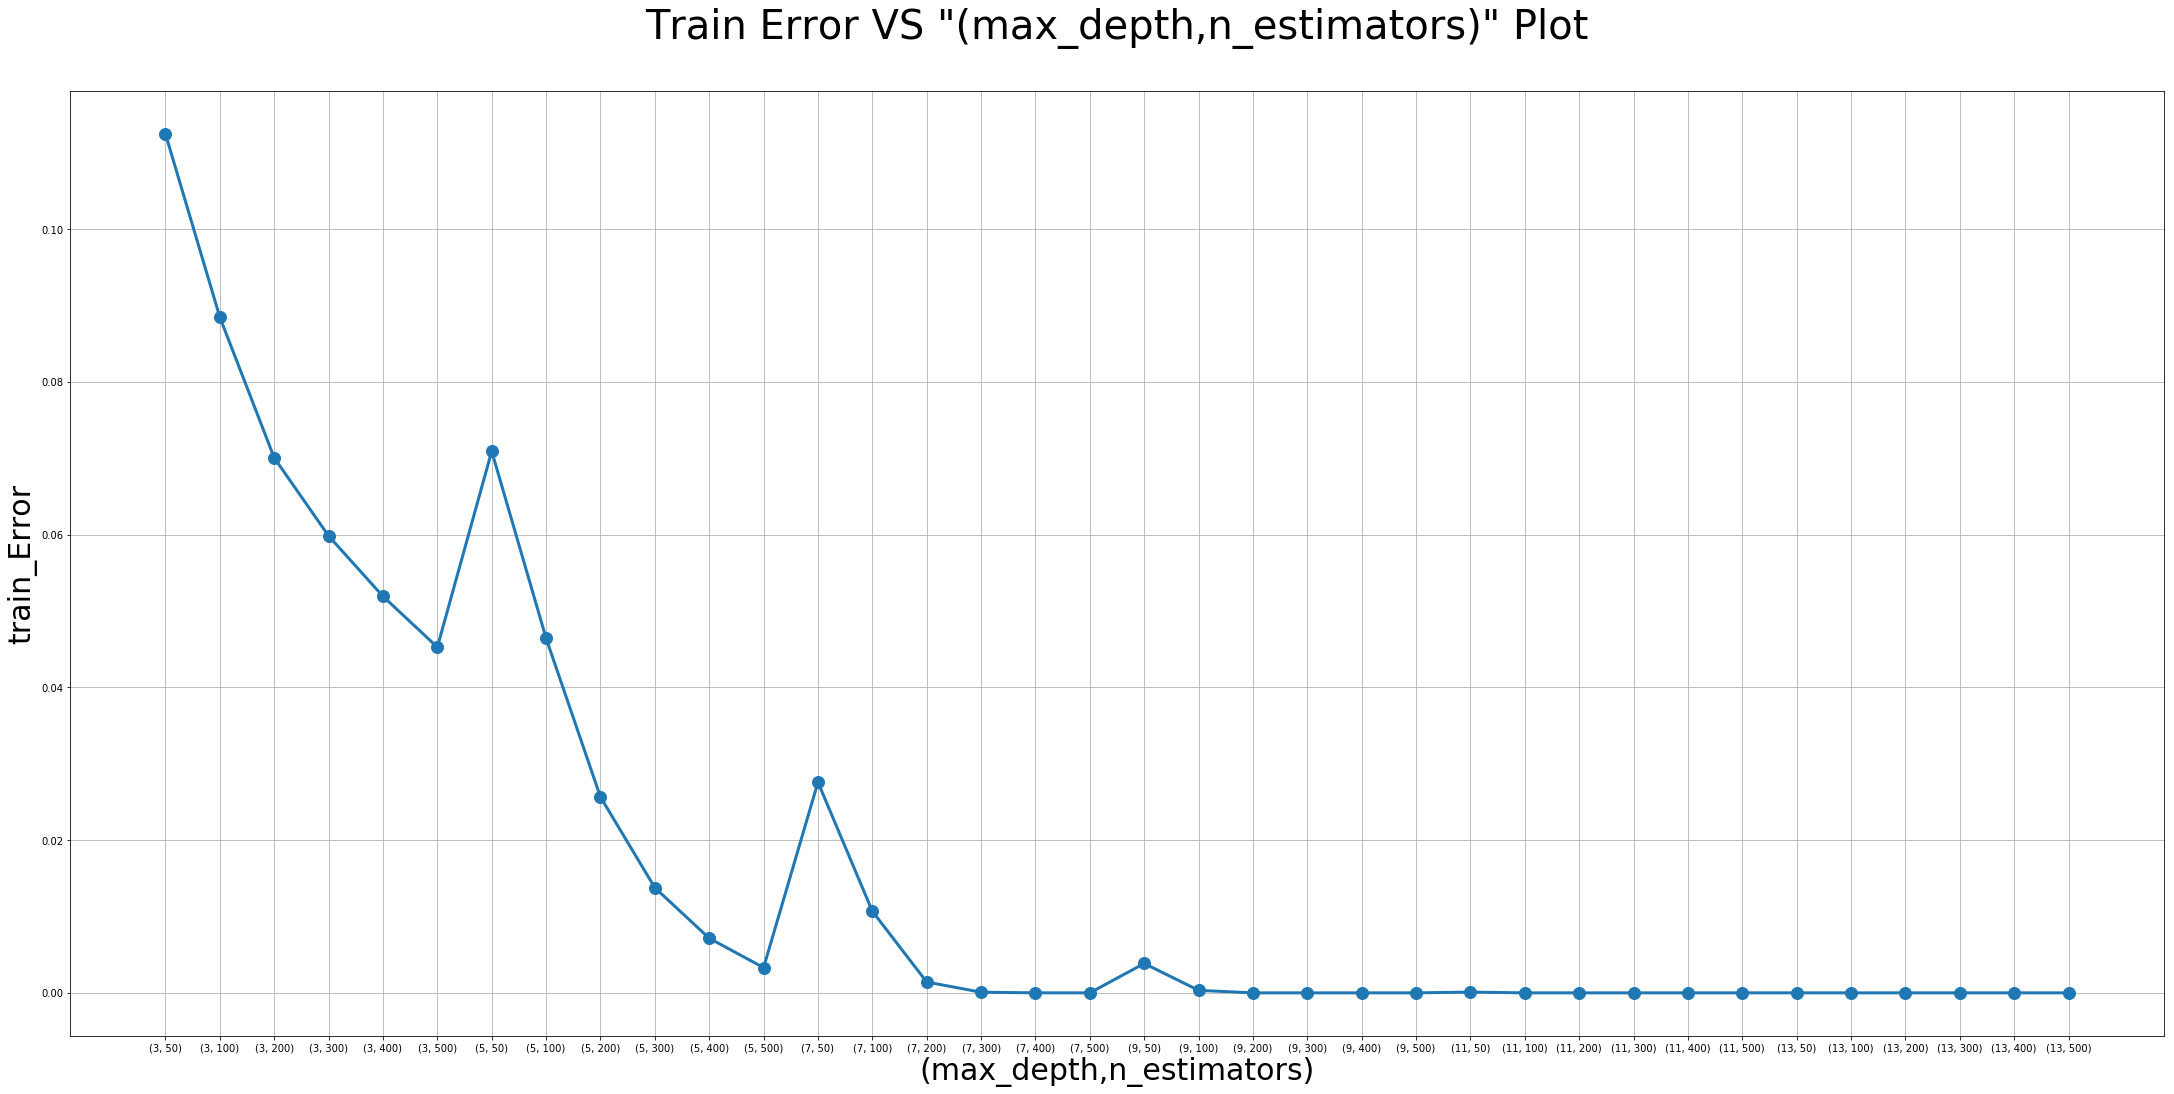

In [168]:
# Cross-Validation errors
cv_errors1 = [1-i for i in model_xgb3.cv_results_['mean_train_score']]
# plotting Cross-Validation Error vs tuples of (max_depth,n_estimators) graph  
plt.figure(figsize=(30,15))
plt.plot(data, cv_errors1,linewidth=3, marker='o',markersize=12)
plt.xlabel('(max_depth,n_estimators)',size=30)
plt.ylabel('train_Error',size=30)
plt.title('Train Error VS "(max_depth,n_estimators)" Plot\n',size=40)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

Heatmap representation of AUC value of Max_depth & n_estimator on train data as follows:

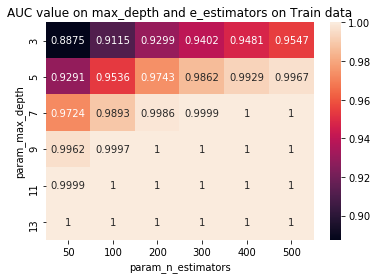

In [169]:
df_gridsearch1 = pd.DataFrame(model_xgb3.cv_results_)
max_scores1 = df_gridsearch1.groupby(['param_max_depth','param_n_estimators']).max()
max_scores1 = max_scores1.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores1.mean_train_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on Train data')
plt.show()

Confusion Matrix of Train Data as follows:

In [170]:
pred_train= model_xgb3.predict(avgw2v_train)
cm = confusion_matrix(y_train, pred_train)
cm

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[ 6788,     0],
       [    0, 42212]], dtype=int64)

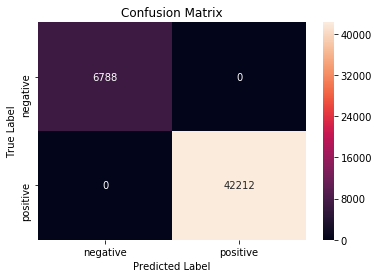

In [171]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Result on Test Data of AVG W2V

In [172]:
clf_3 = XGBClassifier(booster='gbtree',max_depth=13,n_estimators=500)
clf_3.fit(avgw2v_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=13, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

ROC Curve of Train data and Test Data on fpr(false positive rate) and tpr(true positive rate) as follows:

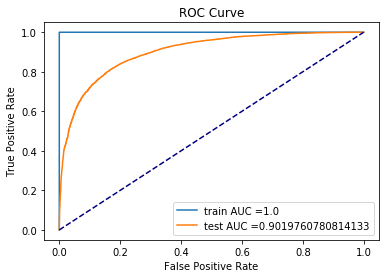

In [177]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_3.predict_proba(avgw2v_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_3.predict_proba(avgw2v_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

In [178]:
pred = clf_3.predict(avgw2v_test)
pred_prob = clf_3.predict_proba(avgw2v_test)[:,1]

print("AUC value on test data:",roc_auc_score(y_test, pred_prob))

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


AUC value on test data: 0.9019760780814133


Confusion Matrix of Test Data as follows:

In [179]:
cm = confusion_matrix(y_test, pred)
cm

array([[ 2315,  2968],
       [  672, 24045]], dtype=int64)

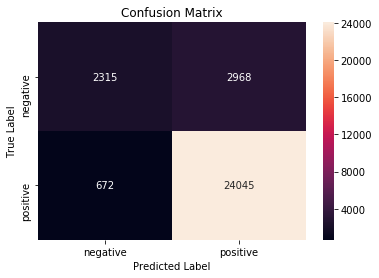

In [180]:
# plot confusion matrix to describe the performance of classifier.
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [181]:
# To show main classification report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.78      0.44      0.56      5283
          1       0.89      0.97      0.93     24717

avg / total       0.87      0.88      0.86     30000



### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [182]:
#Hyperparameter tuning
estimators = [50,100,200,300,400,500]
Depths = [3,5,7,9,11,13]

param_grid = {'n_estimators': estimators, 'max_depth':Depths }
XGB = XGBClassifier(booster='gbtree')
model_xgb4 = GridSearchCV(XGB, param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1,pre_dispatch=2)
model_xgb4.fit(tfw2v_train, y_train)


print("Model with best parameters :\n",model_xgb4.best_estimator_)
##Optimal value of max_depth
optimal_depth = model_xgb4.best_estimator_.max_depth
print("The optimal value of max depth of base model is : ",optimal_depth)

#Optimal value of n_estimators
optimal_estimator = model_xgb4.best_estimator_.n_estimators
print("The optimal value of n_estimator is : ",optimal_estimator)
print("AUC value on Train data:", model_xgb4.best_score_)
print("AUC value on CV data:",model_xgb4.score(tfw2v_cv, y_cv))

Model with best parameters :
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
The optimal value of max depth of base model is :  9
The optimal value of n_estimator is :  50
AUC value on Train data: 0.5128933193911537
AUC value on CV data: 0.5122376485151026


Graph representation of CV error v/s Max_depth & n_estimator on cv data of TFIDF W2V as follows:

In [183]:
# Cross-Validation errors
cv_errors = [1-i for i in model_xgb4.cv_results_['mean_test_score']]

arr_depth=model_xgb4.cv_results_['param_max_depth'] 
arr_estimator=model_xgb4.cv_results_['param_n_estimators'] 
data = [] #  List of tuples(depth,estimators)
for i in range(arr_depth.shape[0]):
    data.append(str((arr_depth[i],arr_estimator[i])))

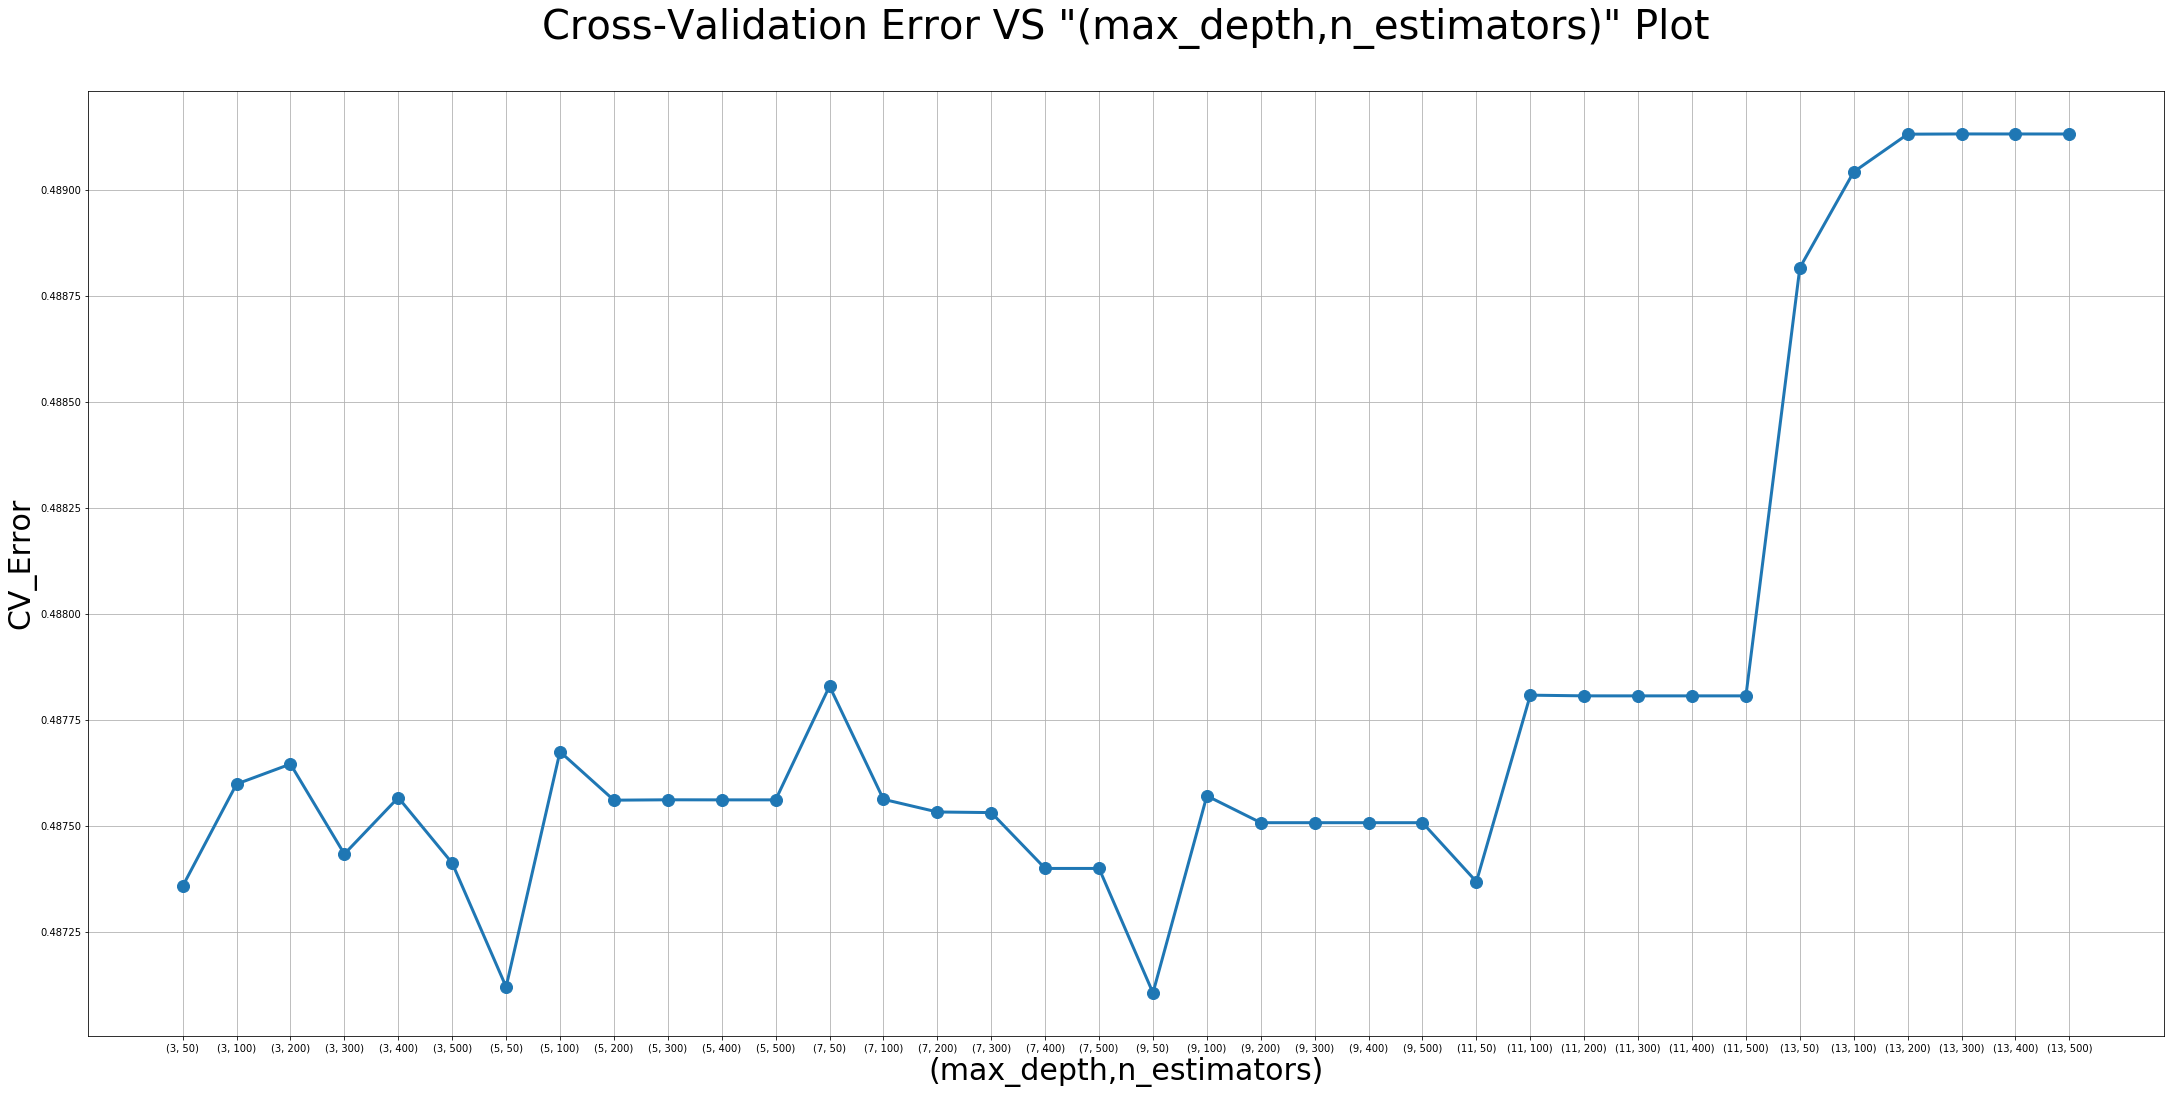

In [184]:
# plotting Cross-Validation Error vs tuples of (max_depth,n_estimators) graph  
plt.figure(figsize=(30,15))
plt.plot(data, cv_errors,linewidth=3, marker='o',markersize=12)
plt.xlabel('(max_depth,n_estimators)',size=30)
plt.ylabel('CV_Error',size=30)
plt.title('Cross-Validation Error VS "(max_depth,n_estimators)" Plot\n',size=40)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

Heatmap representation of AUC value of Max_depth & n_estimator on cv data as follows:

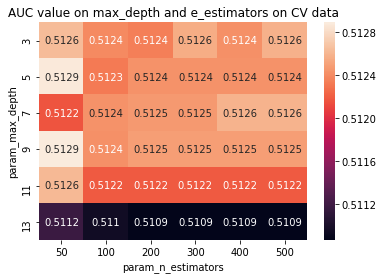

In [185]:
df_gridsearch = pd.DataFrame(model_xgb4.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on CV data')
plt.show()

Graph representation of CV error v/s Max_depth & n_estimator on train data of TFIDF W2V as follows:

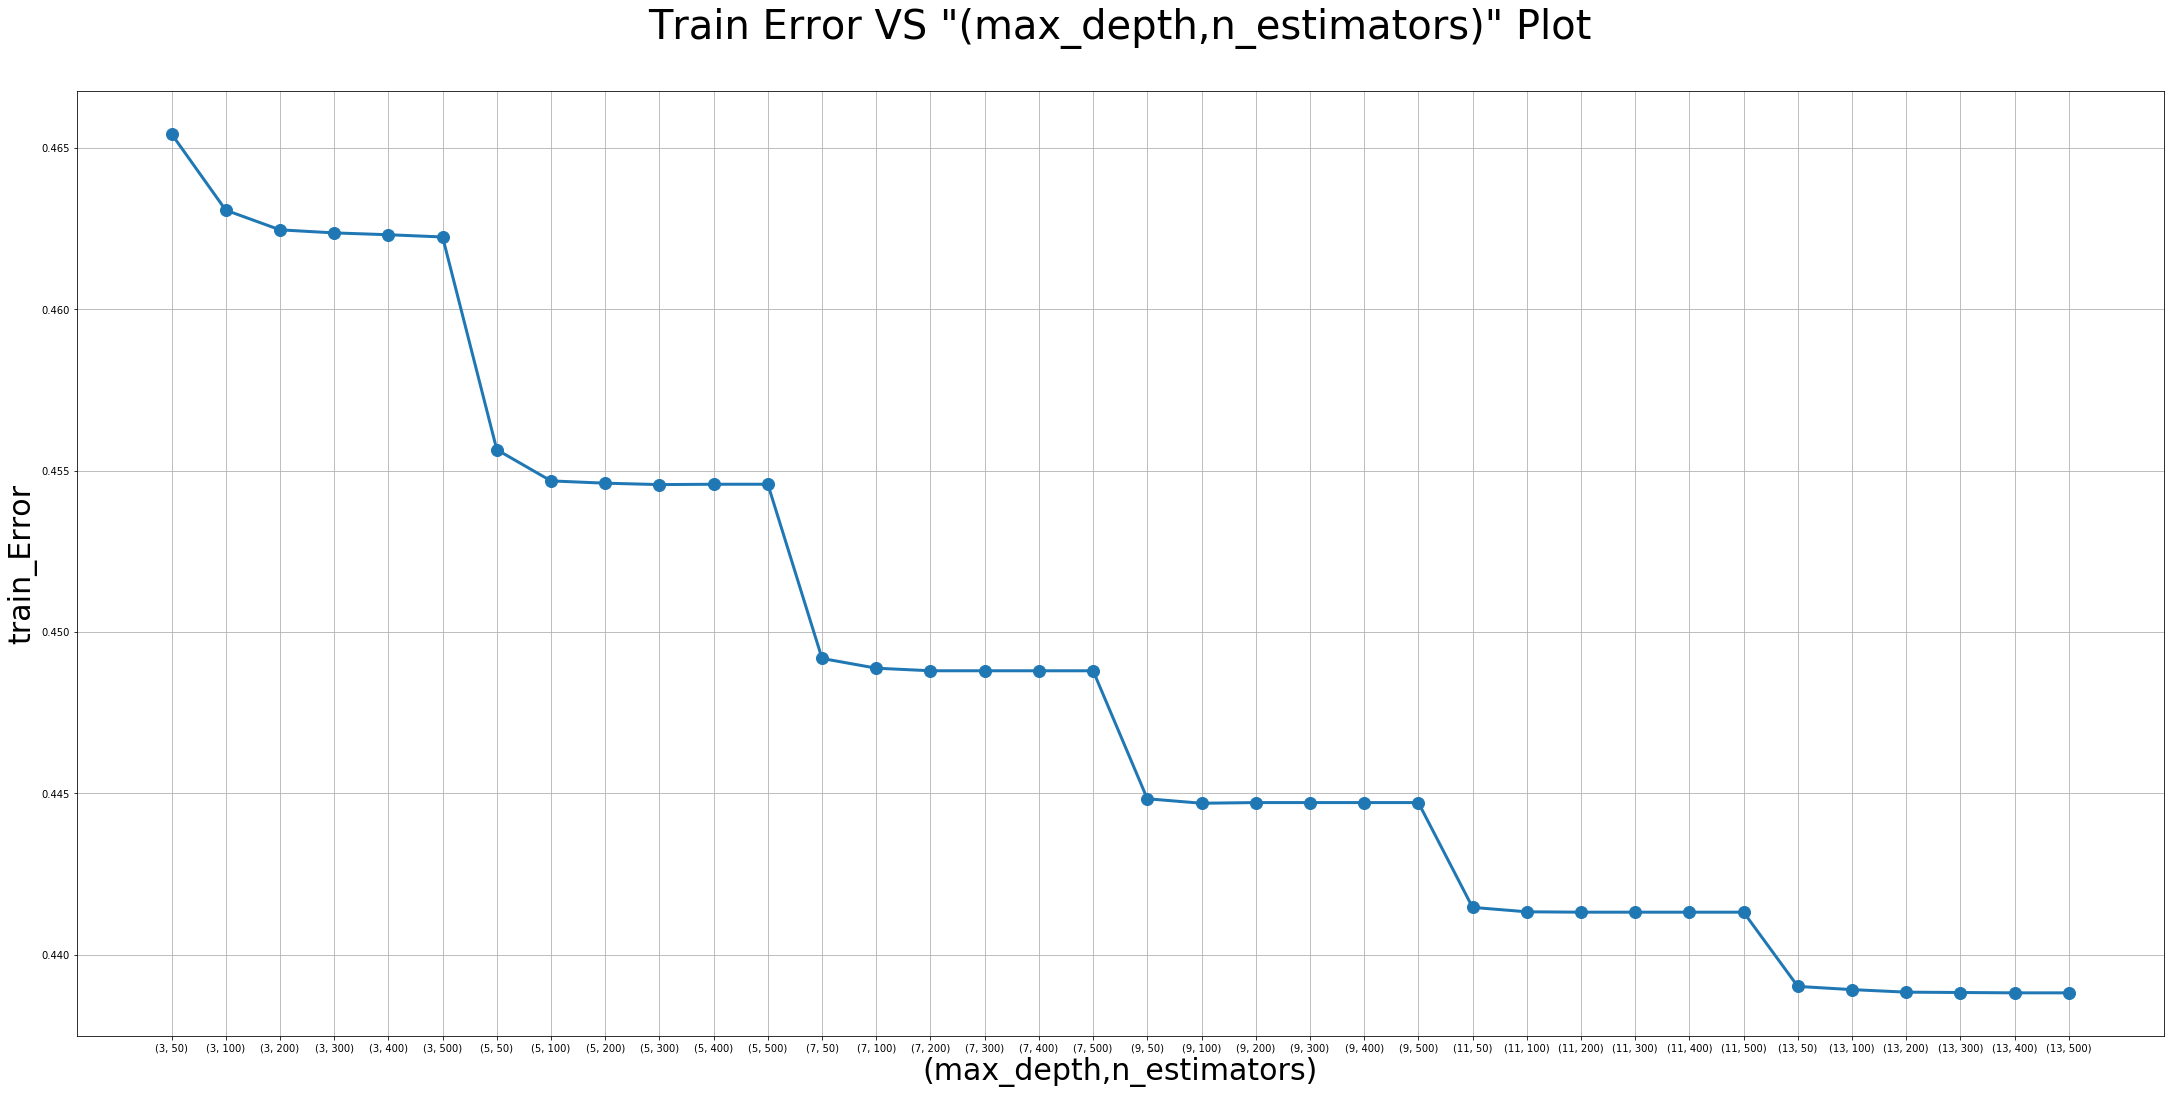

In [186]:
# Cross-Validation errors
cv_errors1 = [1-i for i in model_xgb4.cv_results_['mean_train_score']]
# plotting Cross-Validation Error vs tuples of (max_depth,n_estimators) graph  
plt.figure(figsize=(30,15))
plt.plot(data, cv_errors1,linewidth=3, marker='o',markersize=12)
plt.xlabel('(max_depth,n_estimators)',size=30)
plt.ylabel('train_Error',size=30)
plt.title('Train Error VS "(max_depth,n_estimators)" Plot\n',size=40)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

Heatmap representation of AUC value of Max_depth & n_estimator on train data as follows:

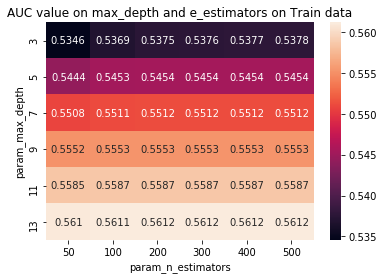

In [187]:
df_gridsearch1 = pd.DataFrame(model_xgb4.cv_results_)
max_scores1 = df_gridsearch1.groupby(['param_max_depth','param_n_estimators']).max()
max_scores1 = max_scores1.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores1.mean_train_score, annot=True, fmt='.4g')
plt.title('AUC value on max_depth and e_estimators on Train data')
plt.show()

Confusion Matrix of Train Data as follows:

In [188]:
pred_train= model_xgb4.predict(tfw2v_train)
cm = confusion_matrix(y_train, pred_train)
cm

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[   74,  6714],
       [    6, 42206]], dtype=int64)

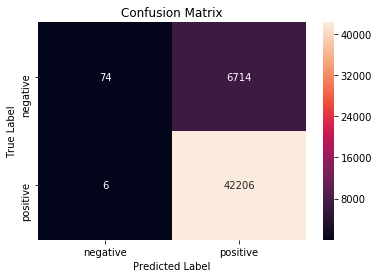

In [189]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Result on Test Data of TFIDF W2V

In [190]:
clf_4 = XGBClassifier(booster='gbtree',max_depth=9,n_estimators=50)
clf_4.fit(tfw2v_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

ROC Curve of Train data and Test Data on fpr(false positive rate) and tpr(true positive rate) as follows:

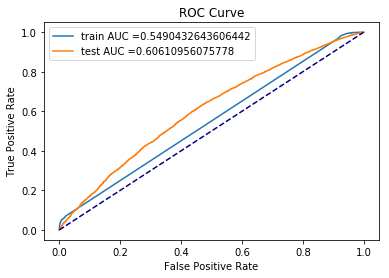

In [191]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_4.predict_proba(tfw2v_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_4.predict_proba(tfw2v_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

In [192]:
pred = clf_4.predict(tfw2v_test)
pred_prob = clf_4.predict_proba(tfw2v_test)[:,1]

print("AUC value on test data:",roc_auc_score(y_test, pred_prob))

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


AUC value on test data: 0.60610956075778


Confusion Matrix of Test Data as follows:

In [193]:
cm = confusion_matrix(y_test, pred)
cm

array([[    0,  5283],
       [    0, 24717]], dtype=int64)

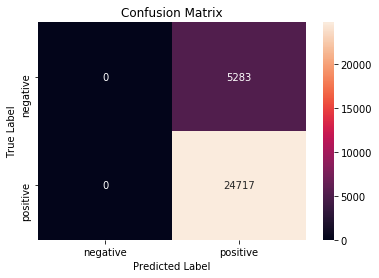

In [194]:
# plot confusion matrix to describe the performance of classifier.
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [195]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00      5283
          1       0.82      1.00      0.90     24717

avg / total       0.68      0.82      0.74     30000



# [6] Conclusions

In [200]:
from prettytable import PrettyTable
ptable = PrettyTable()

vec1 = "BOW"
vec2 = "TFIDF"
vec3 = "AVG-W2V"
vec4 = "TFIDF-W2V"

model1 = 'Random Forest'
model2 = 'GBDT using XGBOOST'


ptable.field_names = ["Vectorizer","Model","Opt_Depth","Opt_learners","Train AUC","Test AUC"]

ptable.add_row([vec1,model1,60,500,0.9953,0.9039])
ptable.add_row([vec1,model2,9,500,0.9941,0.9326])
ptable.add_row([vec2,model1,60,500,0.9979,0.9190])
ptable.add_row([vec2,model2,11,500,0.9986,0.9380])
ptable.add_row([vec3,model1,60,500,0.9999,0.8848])
ptable.add_row([vec3,model2,13,500,1,0.9019])
ptable.add_row([vec4,model1,50,100,0.5593,0.5838])
ptable.add_row([vec4,model2,9,50,0.5490,0.6061])

print(ptable)

+------------+--------------------+-----------+--------------+-----------+----------+
| Vectorizer |       Model        | Opt_Depth | Opt_learners | Train AUC | Test AUC |
+------------+--------------------+-----------+--------------+-----------+----------+
|    BOW     |   Random Forest    |     60    |     500      |   0.9953  |  0.9039  |
|    BOW     | GBDT using XGBOOST |     9     |     500      |   0.9941  |  0.9326  |
|   TFIDF    |   Random Forest    |     60    |     500      |   0.9979  |  0.919   |
|   TFIDF    | GBDT using XGBOOST |     11    |     500      |   0.9986  |  0.938   |
|  AVG-W2V   |   Random Forest    |     60    |     500      |   0.9999  |  0.8848  |
|  AVG-W2V   | GBDT using XGBOOST |     13    |     500      |     1     |  0.9019  |
| TFIDF-W2V  |   Random Forest    |     50    |     100      |   0.5593  |  0.5838  |
| TFIDF-W2V  | GBDT using XGBOOST |     9     |      50      |   0.549   |  0.6061  |
+------------+--------------------+-----------+-------

From above observation, 
1) GBDT using XGBOOST using TFIDF vectorizer gives pretty good performance comparing to others.
2) Seen very less performance  on TFIDF-W2V models
3) Plotted heat maps for better understanding of results